<a href="https://colab.research.google.com/github/SIVASKANDAN-P/sentiment-based-product-recommendation-system/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement
Ebuss has captured a huge market share in many fields, and it sells the products in various categories such as household essentials, books, personal care products, medicines, cosmetic items, beauty products, electrical appliances, kitchen and dining products and health care products.



With the advancement in technology, it is imperative for Ebuss to grow quickly in the e-commerce market to become a major leader in the market because it has to compete with the likes of Amazon, Flipkart, etc., which are already market leaders.



As a senior ML Engineer, you are asked to build a model that will improve the recommendations given to the users given their past reviews and ratings.



In order to do this, you planned to build a sentiment-based product recommendation system

# Importing necessary modules

In [222]:
!pip install ydata_profiling

Importing Necessary Modules

In [223]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import chardet
import seaborn as sns
from ydata_profiling import ProfileReport
import copy
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.model_selection import train_test_split
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pickle
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from datetime import datetime

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

#**Defining necessary functions**

All the functions used in analysis and modeling is placed below for more redablity.

In [224]:
def fileopen(path):
  '''
  Detects the encoding of the file and Returns the file in given path.
  '''
  with open(path, "rb") as f:
    encoding = chardet.detect(f.read())["encoding"]
    file = pd.read_csv(filepath_or_buffer=path,encoding = encoding)
  return file

In [225]:
def isnull(df):
    '''
    dataframe is passed and returns the null columns and its count
    '''
    df1=pd.DataFrame()
    df1['nullcount'] = df.isna().sum()[df.isnull().sum()>0]
    df1['nullpercent']= df1.nullcount.apply(lambda x: x/len(df)*100)
    return df1

In [226]:
def uniq_dict(df,col):
  '''
  Creating a dict with uniques values in column and corresponding index starting
  from zero to length of unique values.
  '''
  uniq = list(df[col].unique()) # list of unique values in columns
  print("No of unique values : {}".format(len(uniq)))
  ind = range(0,len(df[col].unique())) # mapping value starting from 0 to list of columns
  result = dict(map(lambda x, y: (x,y), uniq, ind)) #creating dictionary mapping between unq and idx
  return result

In [227]:
def mapper(df,col):
  '''
  Mapping the unique value with numeric index starting from 0 to length of unique
  value
  '''
  print(col+" : ")
  dic = uniq_dict(df,col)
  df[col]=df[col].apply(lambda x: dic[x])
  return df

In [228]:
def duplicate_remove(df,set):
  '''
  The function removes the dulicated rows where the same user (username) has given review for same product (multiple times).
  The set parameter can be used to take whether min rating or max rating to specify which row needs to be retained.
  '''
  df['duplicate_review'] = df.duplicated(['reviews_username','name'])
  df['remove_flag'] = 1
  # creating a array of duplicated rows index
  duplic_ent_idx = df.loc[df['duplicate_review'] == True].index
  #looping through each index
  for i in duplic_ent_idx:
    # getting the duplicated rows by matching username and name columns
    duplicated_rows = df.loc[((review['reviews_username'] == df.loc[i]['reviews_username']) & (df['name'] == df.loc[i]['name']))]
    max_rating = duplicated_rows['reviews_rating'].max()
    min_rating = duplicated_rows['reviews_rating'].min()
    flag = 0
    if set == 'max':
      for j in duplicated_rows.index:
        if df.loc[j]['reviews_rating'] == max_rating and flag == 0:
          flag = 1
        else:
          df.loc[j,'remove_flag'] = 0
    elif set == 'min':
      for j in duplicated_rows.index:
        if df.loc[j]['reviews_rating'] == min_rating and flag == 0:
          flag = 1
        else:
          df.loc[j,'remove_flag'] = 0
  df = df[df['remove_flag'] != 0]
  df = df.drop(['duplicate_review','remove_flag'],axis = 1)
  return df



In [229]:
# Function to display scores
def evaluation_scores(classifier, X_test, y_test):

  # Calculating Predicted value
  y_pred = classifier.predict(X_test)

  # Create confusion matrix
  conf_m = confusion_matrix(y_test, y_pred)

  print("Visualizing the Confusion Matrix with a Heatmap")
  print("\n")
  print("*"*50)
  # Visualize Confusion Matrix with heatmap
  fig, ax = plt.subplots(figsize=(6, 6))
  ax = sns.heatmap(confusion_matrix(y_test, y_pred),
                  annot=True,
                  cbar=False,
                  cmap="RdYlGn", fmt = '0.1f')
  plt.xlabel("Actual label")
  plt.ylabel("Predicted label")
  plt.show()
  print("*"*50)
  print("\n")

  # Calculating the values of True Positives, True Negatives, False Positivies and False Negatives
  TP = conf_m[1][1]
  TN = conf_m[0][0]
  FP = conf_m[0][1]
  FN = conf_m[1][0]

  print("Values of True Positives, True Negatives, False Positivies and False Negatives")
  print("~"*50)
  print('True Positives:', TP)
  print('True Negatives:', TN)
  print('False Positives:', FP)
  print('False Negatives:', FN)
  print("~"*50)
  print("\n")

  # Calculating Accuracy
  accuracy = accuracy_score(y_test, y_pred)
  accuracy = round(accuracy,2)

  # Calculating Sensitivity/Recall
  sensitivity_recall = (TP / float(TP + FN))
  sensitivity_recall = round(sensitivity_recall,2)

  # Calculating Specificity
  specificity = (TN / float(TN + FP))
  specificity = round(specificity,2)

  # Calculating Precision
  precision = (TP / float(TP + FP))
  precision = round(precision,2)

  # Calculating F_1 score
  F1_score = 2 * ((precision * sensitivity_recall) / (precision + sensitivity_recall))
  F1_score = round(F1_score,2)

  print("Evaluation Score Summary")
  print('-'*50)
  print(f'Accuracy Score: {round(accuracy,2)}')
  print(f'Sensitivity/Recall Score: {round(sensitivity_recall,2)}')
  print(f'Specificity Score: {round(specificity,2)}')
  print(f'Precision: {round(precision,2)}')
  print(f'F1 Score: {round(F1_score,2)}')
  print('-'*50)

  # Returning evaluation results for comparison later
  evaluation_metrics = []
  evaluation_metrics.append(accuracy)
  evaluation_metrics.append(sensitivity_recall)
  evaluation_metrics.append(specificity)
  evaluation_metrics.append(precision)
  evaluation_metrics.append(F1_score)

  return evaluation_metrics

In [230]:
def pattern_check(text,pattern):
  '''
  This function check if there is a match for given pattern
  '''
  return re.search(pattern = pattern, string=text)

In [231]:
def store_model(model,name):
  '''
  This function is used to store the model in pickel file
  '''
  # datetime object containing current date and time
  now = datetime.now()
  with open("/content/drive/MyDrive/sentiment-based product recommendation system/{}_{}.pkl".format(name,now), "wb") as f:
    pickle.dump(model, f)

In [232]:
def text_preprocessing(sent):
  '''
  This function doese necessary preprocessing steps lower casing text, removing punctuations
  and removing stop words
  '''
  sent=sent.lower()
  sent=re.sub(r'[^\w\s]','',sent)
  word_tokens = word_tokenize(sent)
  clean_sent = [w for w in word_tokens if not w.lower() in stop_words]
  fin_sent=''
  first = True
  for w in clean_sent:
    if first:
      fin_sent = fin_sent + w
      first = False
    else:
      fin_sent = fin_sent + " " + w
  return fin_sent


In [233]:
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [234]:
#Function to lemmatize the text
def clean_lemma(text):
  '''
  This function lemmatizes the give text
  '''
  sent = []
  doc = nlp(text)
  for token in doc:
    sent.append(token.lemma_)
  return " ".join(sent)

#Loading data

Loading the input data into data frame

In [235]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [236]:
# Loading the input file and field description file
desc = fileopen("/content/drive/MyDrive/sentiment-based product recommendation system/Data+Attribute+Description.csv")
review = fileopen("/content/drive/MyDrive/sentiment-based product recommendation system/sample30.csv")


In [237]:
review.head()

id            brand  \
0  AV13O1A8GV-KLJ3akUyj  Universal Music   
1  AV14LG0R-jtxr-f38QfS         Lundberg   
2  AV14LG0R-jtxr-f38QfS         Lundberg   
3  AV16khLE-jtxr-f38VFn              K-Y   
4  AV16khLE-jtxr-f38VFn              K-Y   

                                          categories  \
0  Movies, Music & Books,Music,R&b,Movies & TV,Mo...   
1  Food,Packaged Foods,Snacks,Crackers,Snacks, Co...   
2  Food,Packaged Foods,Snacks,Crackers,Snacks, Co...   
3  Personal Care,Medicine Cabinet,Lubricant/Sperm...   
4  Personal Care,Medicine Cabinet,Lubricant/Sperm...   

                         manufacturer  \
0  Universal Music Group / Cash Money   
1                            Lundberg   
2                            Lundberg   
3                                 K-Y   
4                                 K-Y   

                                         name              reviews_date  \
0   Pink Friday: Roman Reloaded Re-Up (w/dvd)  2012-11-30T06:21:45.000Z   
1  Lundberg Organic Cinnamon Toast Rice Cakes  2017-07-09T00:00:00.000Z   
2  Lundberg Organic Cinnamon Toast Rice Cakes  2017-07-09T00:00:00.000Z   
3            K-Y Love Sensuality Pleasure Gel  2016-01-06T00:00:00.000Z   
4            K-Y Love Sensuality Pleasure Gel  2016-12-21T00:00:00.000Z   

  reviews_didPurchase reviews_doRecommend  reviews_rating  \
0                 NaN                 NaN               5   
1                True                 NaN               5   
2                True                 NaN               5   
3               False               False               1   
4               False               False               1   

                                        reviews_text reviews_title  \
0  i love this album. it's very good. more to the...  Just Awesome   
1  Good flavor. This review was collected as part...          Good   
2                                       Good flavor.          Good   
3  I read through the reviews on here before look...  Disappointed   
4  My husband bought this gel for us. The gel cau...    Irritation   

  reviews_userCity reviews_userProvince reviews_username user_sentiment  
0      Los Angeles                  NaN           joshua       Positive  
1              NaN                  NaN        dorothy w       Positive  
2              NaN                  NaN        dorothy w       Positive  
3              NaN                  NaN          rebecca       Negative  
4              NaN                  NaN        walker557       Negative

In [238]:
desc

Attribute                              Attribute Description
0                     id  Uniques identity number to identify each uniqu...
1                  brand  Name of the brand of the product to which user...
2             categories  Category of the product like household essenti...
3           manufacturer            Name of the manufacturer of the product
4                   name  Name of the product to which user has added re...
5           reviews_date  Date on which the review has been added by the...
6    reviews_didPurchase  Whether a particular user has purchased the pr...
7    reviews_doRecommend  Whether a particular user has recommended the ...
8         reviews_rating   Rating given by the user to a particular product
9           reviews_text   Review given by the user to a particular product
10         reviews_title  The title of the review given by the user to a...
11      reviews_userCity                      The residing city of the user
12  reviews_userProvince                  The residing province of the user
13      reviews_username  The unique identification for individual user ...
14        user_sentiment  The overall sentiment of the user for a partic...

In [239]:
review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

Convert all columns to appropriate data types

In [240]:
# Using dtypes function to convert all columns to appropriate data types.
review = review.convert_dtypes()

In [241]:
review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    30000 non-null  string 
 1   brand                 30000 non-null  string 
 2   categories            30000 non-null  string 
 3   manufacturer          29859 non-null  string 
 4   name                  30000 non-null  string 
 5   reviews_date          29954 non-null  string 
 6   reviews_didPurchase   15932 non-null  boolean
 7   reviews_doRecommend   27430 non-null  boolean
 8   reviews_rating        30000 non-null  Int64  
 9   reviews_text          30000 non-null  string 
 10  reviews_title         29810 non-null  string 
 11  reviews_userCity      1929 non-null   string 
 12  reviews_userProvince  170 non-null    string 
 13  reviews_username      29937 non-null  string 
 14  user_sentiment        29999 non-null  string 
dtypes: Int64(1), boolea

Removing null Values in date column since date field is assigned has string datatype.

In [242]:
isnull(review)

nullcount  nullpercent
manufacturer                141     0.470000
reviews_date                 46     0.153333
reviews_didPurchase       14068    46.893333
reviews_doRecommend        2570     8.566667
reviews_title               190     0.633333
reviews_userCity          28071    93.570000
reviews_userProvince      29830    99.433333
reviews_username             63     0.210000
user_sentiment                1     0.003333

In [243]:
review[~pd.to_datetime(review.reviews_date, errors='coerce').notnull()]

id                         brand  \
1536   AVpe3_ikilAPnD_xPykq                   Alberto VO5   
1784   AVpe38Uy1cnluZ0-YuJR           Target.com Use Only   
1785   AVpe38Uy1cnluZ0-YuJR           Target.com Use Only   
1786   AVpe38Uy1cnluZ0-YuJR           Target.com Use Only   
1787   AVpe38Uy1cnluZ0-YuJR           Target.com Use Only   
1788   AVpe38Uy1cnluZ0-YuJR           Target.com Use Only   
1789   AVpe38Uy1cnluZ0-YuJR           Target.com Use Only   
1790   AVpe38Uy1cnluZ0-YuJR           Target.com Use Only   
1791   AVpe38Uy1cnluZ0-YuJR           Target.com Use Only   
1792   AVpe38Uy1cnluZ0-YuJR           Target.com Use Only   
1795   AVpe38Uy1cnluZ0-YuJR           Target.com Use Only   
3750   AVpe7tA31cnluZ0-aI-r          Baxter of California   
3752   AVpe7tA31cnluZ0-aI-r          Baxter of California   
4126   AVpe9vHs1cnluZ0-a4TU                         Plano   
18209  AVpfDbSP1cnluZ0-c3wo                        Scotty   
18324  AVpfewoLilAPnD_xcfgU                   Home Health   
18325  AVpfewoLilAPnD_xcfgU                   Home Health   
18326  AVpfewoLilAPnD_xcfgU                   Home Health   
18368  AVpfGTRQLJeJML432WYA                   Burt's Bees   
18369  AVpfGTRQLJeJML432WYA                   Burt's Bees   
18371  AVpfGTRQLJeJML432WYA                   Burt's Bees   
18404  AVpfgvkJLJeJML43-g1y          Warner Manufacturing   
18407  AVpfgvkJLJeJML43-g1y          Warner Manufacturing   
18408  AVpfgvkJLJeJML43-g1y          Warner Manufacturing   
18409  AVpfgvkJLJeJML43-g1y          Warner Manufacturing   
18410  AVpfgvkJLJeJML43-g1y          Warner Manufacturing   
20655  AVpfKb8k1cnluZ0-fQdA              Head & Shoulders   
21993  AVpfNfEMLJeJML434uf-  UNIVERSAL HOME ENTERTAINMENT   
21994  AVpfNfEMLJeJML434uf-  UNIVERSAL HOME ENTERTAINMENT   
21995  AVpfNfEMLJeJML434uf-  UNIVERSAL HOME ENTERTAINMENT   
21996  AVpfNfEMLJeJML434uf-  UNIVERSAL HOME ENTERTAINMENT   
21997  AVpfNfEMLJeJML434uf-  UNIVERSAL HOME ENTERTAINMENT   
21998  AVpfNfEMLJeJML434uf-  UNIVERSAL HOME ENTERTAINMENT   
21999  AVpfNfEMLJeJML434uf-  UNIVERSAL HOME ENTERTAINMENT   
22000  AVpfNfEMLJeJML434uf-  UNIVERSAL HOME ENTERTAINMENT   
22001  AVpfNfEMLJeJML434uf-  UNIVERSAL HOME ENTERTAINMENT   
22002  AVpfNfEMLJeJML434uf-  UNIVERSAL HOME ENTERTAINMENT   
26213  AVpfPkrkilAPnD_xX-L9                        Finish   
26214  AVpfPkrkilAPnD_xX-L9                        Finish   
26215  AVpfPkrkilAPnD_xX-L9                        Finish   
26216  AVpfPkrkilAPnD_xX-L9                        Finish   
26219  AVpfPkrkilAPnD_xX-L9                        Finish   
26220  AVpfPkrkilAPnD_xX-L9                        Finish   
26761  AVpfP-rELJeJML435jEN                           LDR   
28421  AVpfSFDo1cnluZ0-hwjT            Concept Housewares   
28422  AVpfSFDo1cnluZ0-hwjT            Concept Housewares   
28423  AVpfSFDo1cnluZ0-hwjT            Concept Housewares   
28424  AVpfSFDo1cnluZ0-hwjT            Concept Housewares   
28425  AVpfSFDo1cnluZ0-hwjT            Concept Housewares   
28426  AVpfSFDo1cnluZ0-hwjT            Concept Housewares   
28427  AVpfSFDo1cnluZ0-hwjT            Concept Housewares   
28428  AVpfSFDo1cnluZ0-hwjT            Concept Housewares   
28437  AVpfSvmGilAPnD_xY_gE                      Barielle   
28713  AVpfTVkcilAPnD_xZLts                  Queen Helene   

                                              categories  \
1536   Personal Care,Hair Care,Shampoo,Beauty,Shampoo...   
1784   Movies, Music & Books,Movies,Music,All MGM Tit...   
1785   Movies, Music & Books,Movies,Music,All MGM Tit...   
1786   Movies, Music & Books,Movies,Music,All MGM Tit...   
1787   Movies, Music & Books,Movies,Music,All MGM Tit...   
1788   Movies, Music & Books,Movies,Music,All MGM Tit...   
1789   Movies, Music & Books,Movies,Music,All MGM Tit...   
1790   Movies, Music & Books,Movies,Music,All MGM Tit...   
1791   Movies, Music & Books,Movies,Music,All MGM Tit...   
1792   Movies, Music & Books,Movies,Music,All MGM Tit...   
1795   Mo

There are some rows where dates are NA or having invalid values. Since number of records is less 54. We can drop them.

In [244]:
review['invalid_dates'] = ~pd.to_datetime(review.reviews_date, errors='coerce').notnull()

In [245]:
review[review['invalid_dates']==1].index

Int64Index([ 1536,  1784,  1785,  1786,  1787,  1788,  1789,  1790,  1791,
             1792,  1795,  3750,  3752,  4126, 18209, 18324, 18325, 18326,
            18368, 18369, 18371, 18404, 18407, 18408, 18409, 18410, 20655,
            21993, 21994, 21995, 21996, 21997, 21998, 21999, 22000, 22001,
            22002, 26213, 26214, 26215, 26216, 26219, 26220, 26761, 28421,
            28422, 28423, 28424, 28425, 28426, 28427, 28428, 28437, 28713],
           dtype='int64')

In [246]:
review = review.drop(index=review[review['invalid_dates']==1].index)
review[review['invalid_dates']==1]

Empty DataFrame
Columns: [id, brand, categories, manufacturer, name, reviews_date, reviews_didPurchase, reviews_doRecommend, reviews_rating, reviews_text, reviews_title, reviews_userCity, reviews_userProvince, reviews_username, user_sentiment, invalid_dates]
Index: []

In [247]:
review = review.drop(columns='invalid_dates')

In [248]:
review['reviews_date'] = pd.to_datetime(review.reviews_date, infer_datetime_format=True)

In [249]:
review.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29946 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   id                    29946 non-null  string             
 1   brand                 29946 non-null  string             
 2   categories            29946 non-null  string             
 3   manufacturer          29805 non-null  string             
 4   name                  29946 non-null  string             
 5   reviews_date          29946 non-null  datetime64[ns, UTC]
 6   reviews_didPurchase   15924 non-null  boolean            
 7   reviews_doRecommend   27422 non-null  boolean            
 8   reviews_rating        29946 non-null  Int64              
 9   reviews_text          29946 non-null  string             
 10  reviews_title         29756 non-null  string             
 11  reviews_userCity      1929 non-null   string             
 12  revi

In [250]:
review.shape

(29946, 15)

# Handling Null Values

In [251]:
review[review.user_sentiment.isna()]

id   brand  \
28354  AVpfRTh1ilAPnD_xYic2  Disney   

                                              categories manufacturer  \
28354  Movies, Music & Books,Movies,Kids' & Family,Wa...  Walt Disney   

                                                    name  \
28354  Planes: Fire Rescue (2 Discs) (includes Digita...   

                   reviews_date  reviews_didPurchase  reviews_doRecommend  \
28354 2014-11-07 00:00:00+00:00                 <NA>                 True   

       reviews_rating                                       reviews_text  \
28354               5  my kids absolutely loved this film so much tha...   

                                         reviews_title reviews_userCity  \
28354  a super hit with my children. they loved it!!??             <NA>   

      reviews_userProvince reviews_username user_sentiment  
28354                mamad         7.87E+11           <NA>

The review is a positive review hence we can map it has positve

In [252]:
review.user_sentiment.fillna('Positive', inplace=True)

Droping rows without username

In [253]:
review = review[~ review.reviews_username.isna() ]

Droping rows without review title

In [254]:
review[ review.reviews_title.isna() ]

id                 brand  \
1239   AV1YneDPglJLPUi8IJyQ                Finish   
1441   AVpe_dxlilAPnD_xSiHI  The Seaweed Bath Co.   
1442   AVpe_dxlilAPnD_xSiHI  The Seaweed Bath Co.   
1443   AVpe_dxlilAPnD_xSiHI  The Seaweed Bath Co.   
1444   AVpe_dxlilAPnD_xSiHI  The Seaweed Bath Co.   
...                     ...                   ...   
28790  AVpfvieo1cnluZ0-qdnu         L'Oreal Paris   
28791  AVpfvieo1cnluZ0-qdnu         L'Oreal Paris   
28792  AVpfvieo1cnluZ0-qdnu         L'Oreal Paris   
28793  AVpfvieo1cnluZ0-qdnu         L'Oreal Paris   
28794  AVpfvieo1cnluZ0-qdnu         L'Oreal Paris   

                                              categories       manufacturer  \
1239   Household Essentials,Cleaning Supplies,Dish De...  Reckitt Benckiser   
1441   Personal Care,Hair Care,Conditioner,Beauty,Sha...   The Seaweed Bath   
1442   Personal Care,Hair Care,Conditioner,Beauty,Sha...   The Seaweed Bath   
1443   Personal Care,Hair Care,Conditioner,Beauty,Sha...   The Seaweed Bath   
1444   Personal Care,Hair Care,Conditioner,Beauty,Sha...   The Seaweed Bath   
...                                                  ...                ...   
28790  Personal Care,Hair Care,Styling Gel/Lotion,Bea...            Generic   
28791  Personal Care,Hair Care,Styling Gel/Lotion,Bea...            Generic   
28792  Personal Care,Hair Care,Styling Gel/Lotion,Bea...            Generic   
28793  Personal Care,Hair Care,Styling Gel/Lotion,Bea...            Generic   
28794  Personal Care,Hair Care,Styling Gel/Lotion,Bea...            Generic   

                                                    name  \
1239   Finish Quantum Dishwasher Detergent, Lemon Spa...   
1441   The Seaweed Bath Co. Argan Conditioner, Smooth...   
1442   The Seaweed Bath Co. Argan Conditioner, Smooth...   
1443   The Seaweed Bath Co. Argan Conditioner, Smooth...   
1444   The Seaweed Bath Co. Argan Conditioner, Smooth...   
...                                                  ...   
28790  L'oreal Paris Advanced Hairstyle TXT IT Hyper-...   
28791  L'oreal Paris Advanced Hairstyle TXT IT Hyper-...   
28792  L'oreal Paris Advanced Hairstyle TXT IT Hyper-...   
28793  L'oreal Paris Advanced Hairstyle TXT IT Hyper-...   
28794  L'oreal Paris Advanced Hairstyle TXT IT Hyper-...   

                   reviews_date  reviews_didPurchase  reviews_doRecommend  \
1239  2017-11-16 08:12:30+00:00                 <NA>                 True   
1441  2013-11-07 00:00:00+00:00                 <NA>                 <NA>   
1442  2015-02-09 00:00:00+00:00                 <NA>                 <NA>   
1443  2013-11-07 00:00:00+00:00                 <NA>                 <NA>   
1444  2017-11-27 18:18:38+00:00                 <NA>                 True   
...                         ...                  ...                  ...   
28790 2014-02-28 00:00:00+00:00                 <NA>                 <NA>   
28791 2014-09-04 00:00:00+00:00                 <NA>                 <NA>   
28792 2015-04-17 00:00:00+00:00                 <NA>                 <NA>   
28793 2014-06-24 00:00:00+00:00                 <NA>                 <NA>   
28794 2014-08-21 00:00:00+00:00                 <NA>                 <NA>   

       reviews_rating                                       reviews_text  \
1239                5                    Great quality and a great price   
1441                3  Wanted to love this but it's a bit too heavy f...   
1442                3  I have thick coarse hair and for me this just ...   
1443                3  Wanted to love this but it's a bit too heavy f...   
1444                4  I actually really enjoy this conditioner. Have...   
...               ...                                                ...   
28790               5  I have fine hair and don't like heavy hairspra...   
28791               5  I tried this product for the first time im ver...   
28792               5  I am an African American woman who has been na...   
28793               5  works grea

In [255]:
review = review[~ review.reviews_title.isna() ]

In [256]:
isnull(review)

nullcount  nullpercent
manufacturer                141     0.474747
reviews_didPurchase       13777    46.387205
reviews_doRecommend        2336     7.865320
reviews_userCity          27801    93.606061
reviews_userProvince      29535    99.444444

#**EDA**

In [257]:
ProfileReport(review, title="Profiling Report")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [258]:
isnull(review)

nullcount  nullpercent
manufacturer                141     0.474747
reviews_didPurchase       13777    46.387205
reviews_doRecommend        2336     7.865320
reviews_userCity          27801    93.606061
reviews_userProvince      29535    99.444444

1. reviews_doRecommend column has 86.3% of values has True. This Column cannot provide much information to our model.
2. user_sentiment has 1 null value which can be filled manually.
3. reviews_username has 0.21% (count 63) which cannot be filled in any other way. Hence we can remove these rows.
4. The columns manufacturer are not needed for both Sentiment and Recommender models we don't need to handle the NULL values for them.
5. The manufacturer	column has 47 % null value it can be droped.
6. reviews_userProvince, reviews_userCity has more than 90% null values. Hence these columns can be dropped since it cannot provide any value to our model.
7. reviews_didPurchase has 46% null. and it can also be removed. Since this column cannot be filled with in any other way.

Droping columns that are identified in previous step

In [259]:
review.drop(columns=['reviews_userProvince','reviews_userCity','reviews_didPurchase','reviews_doRecommend','manufacturer'], inplace=True)

# Analysis

Analysing the reviews_rating and user sentiment columns

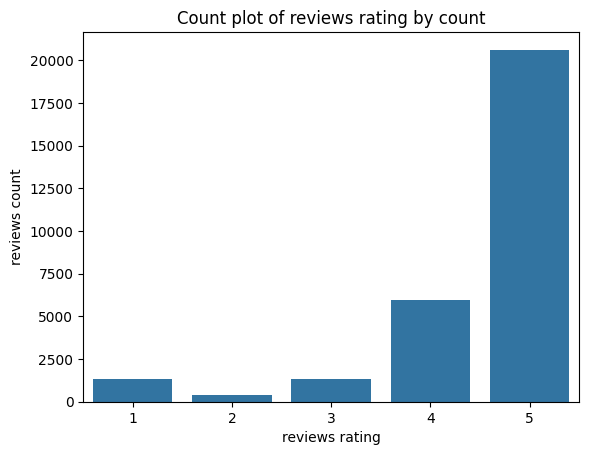

In [260]:
sns.countplot(x = 'reviews_rating', data = review).set(title="Count plot of reviews rating by count", xlabel="reviews rating", ylabel="reviews count")
plt.show()

There is a count of rating 4,5 is very high. This could indicate a class imbalance in data

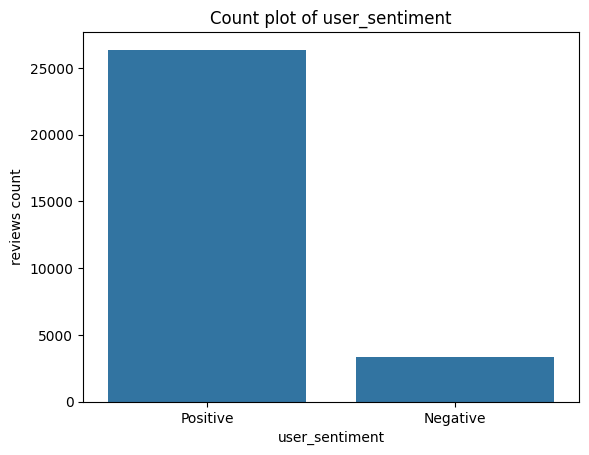

In [261]:
sns.countplot(x = 'user_sentiment', data = review).set(title="Count plot of user_sentiment", xlabel="user_sentiment", ylabel="reviews count")
plt.show()

1. There is a class imbalance since the reviews with positive sentiment is very high.
2. By seeing the Negative sentiment count and count of rating 1,2,3. The count is not similar. It could indicate some anomaly present in data

Lets analyse the negative reviews.

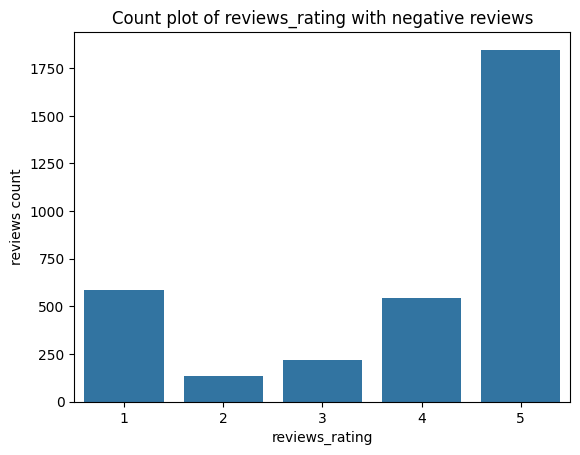

In [262]:
sns.countplot(x = 'reviews_rating', data = review[review['user_sentiment']== 'Negative']).set(title="Count plot of reviews_rating with negative reviews", xlabel="reviews_rating", ylabel="reviews count")
plt.show()

It is surprising to see that we have high count of records with negative sentiment but having 4 or 5 rating. This shows there is anomaly in data.

In [263]:
review[(review['user_sentiment'] == 'Negative') & (review['reviews_rating'] >= 4 )].reviews_rating.value_counts()

5    1847
4     546
Name: reviews_rating, dtype: Int64

We have 2393 records with Negative sentiment but rating is very high.

Lets check Positive sentiment

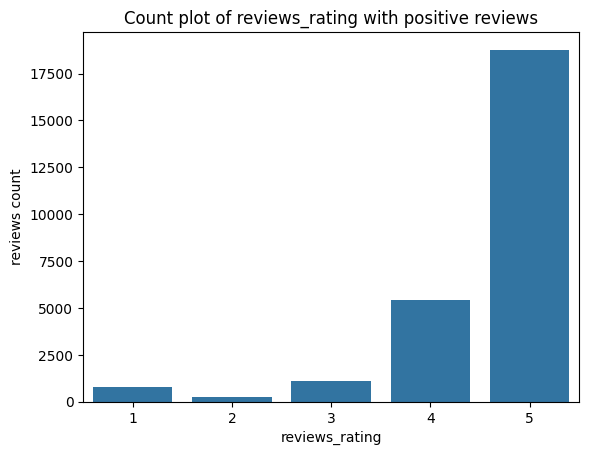

In [264]:
#Let check the distribution of reviews with positive sentiment
sns.countplot(x = 'reviews_rating', data = review[review['user_sentiment']== 'Positive']).set(title="Count plot of reviews_rating with positive reviews", xlabel="reviews_rating", ylabel="reviews count")
plt.show()

Here we have higher count of rating 4 and 5 which is expected. Still we have some records with less rating indicating there is some mislabeling.

Lets analyse the rows of Positive sentiment

In [265]:
review[(review['user_sentiment'] == 'Positive') & (review['reviews_rating'] <= 2 )].reviews_rating.value_counts()

1    776
2    268
Name: reviews_rating, dtype: Int64

We have 820 rows with positive rating sentiment but with less rating

In [266]:
review[(review['user_sentiment'] == 'Negative') & (review['reviews_rating'] >= 4 )][['reviews_text','reviews_rating','user_sentiment']]

reviews_text  reviews_rating  \
92     It hydrates my skin. It is not too thick and h...               4   
96     In only a week I can see the difference in my ...               4   
100    This product has made my skin smoother and sup...               4   
106    I like to use this cream on my neck and collar...               4   
117    I finally found a moisturizing product that wi...               4   
...                                                  ...             ...   
29818  I received a complimentary sample of this prod...               5   
29855  This has prolonged the color in my hair! Not o...               5   
29858  This conditioner makes my hair very soft witho...               5   
29862  This conditioner has become a staple in my hai...               5   
29941  It's very difficult to find a conditioner that...               5   

      user_sentiment  
92          Negative  
96          Negative  
100         Negative  
106         Negative  
117         Negative  
...              ...  
29818       Negative  
29855       Negative  
29858       Negative  
29862       Negative  
29941       Negative  

[2393 rows x 3 columns]

Here we could clearly see that for many of review have wrong sentiment when reading through the text. And also Important thing is most of review has this sentence 'collected as part of promotion'. Lets check how many rows with text promotion is available.

In [267]:
review['Promotional_Reviews'] = review.reviews_text.apply(lambda x: 1 if pattern_check(x,'promotion') else 0)

In [268]:
review['Promotional_Reviews'].value_counts()

0    20957
1     8743
Name: Promotional_Reviews, dtype: int64

We 8743 records with promotion. Lets check if the mislabeling of sentiment and rating is due to these promotional reviews

In [269]:
promotion = review[(review['user_sentiment'] == 'Negative') & (review['Promotional_Reviews'] == 1 )][['reviews_text','reviews_rating','user_sentiment']]

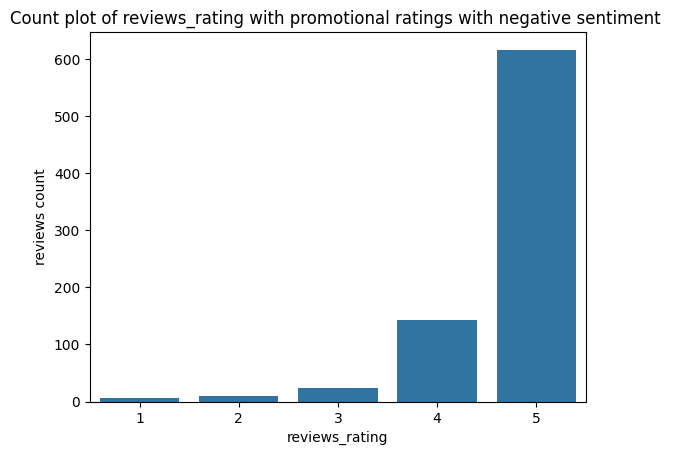

In [270]:
#Let check the distribution of promotional reviews with negative sentiment
sns.countplot(x = 'reviews_rating', data = promotion).set(title="Count plot of reviews_rating with promotional ratings with negative sentiment ", xlabel="reviews_rating", ylabel="reviews count")
plt.show()

The rating are high but sentiment is negative. This could be one of the reason for mismatch between rating and sentiment

Lets check distribution of non promotional negative reviews

In [271]:
promotion = review[(review['user_sentiment'] == 'Negative') & (review['Promotional_Reviews'] == 0 )][['reviews_text','reviews_rating','user_sentiment']]

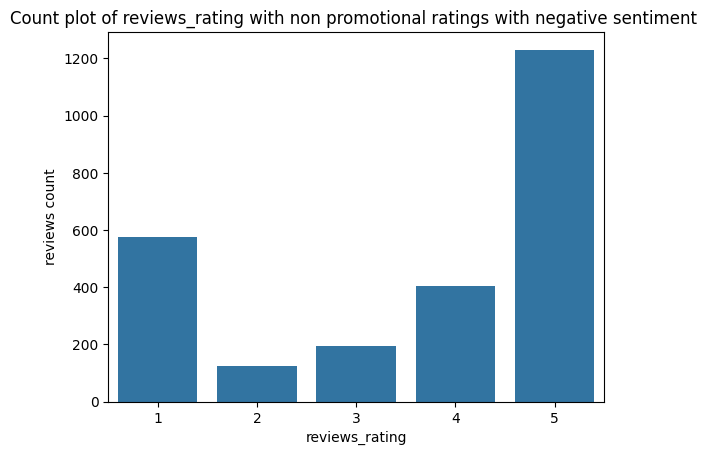

In [272]:
#Let check the distribution of reviews with negative sentiment
sns.countplot(x = 'reviews_rating', data = promotion).set(title="Count plot of reviews_rating with non promotional ratings with negative sentiment ", xlabel="reviews_rating", ylabel="reviews count")
plt.show()

Still we have reviews with rating 5 very high indicating promotional review is not the only cause for this imbalance.

In [273]:
# Number of rows with with negative sentiment with high rating.
review[(review['user_sentiment'] == 'Negative') & (review['reviews_rating'] >= 4 ) ].shape

(2393, 11)

In [274]:
# Number of rows with positive sentiment with low rating
review[(review['user_sentiment'] == 'Positive') & (review['reviews_rating'] <= 2 ) ].shape

(1044, 11)

In [275]:
review.shape

(29700, 11)

We have a total of 3437 rows with mismatching ratings and sentiment. Lets check if it can be updated in any other way.

It will be better if we remove these rows since these rows could reduce the accuracy of the model.

Lets check non promotional mismatching negative reviews.

In [276]:
# Filtering Negative reviews with high rating that are not promotional
review[(review['user_sentiment'] == 'Negative') & (review['reviews_rating'] >= 4 ) & (review['Promotional_Reviews'] == 0 )][['reviews_text','reviews_rating','user_sentiment']]

reviews_text  reviews_rating  \
121    I hate to be picky, but who was responsible fo...               4   
153    I have used the product since I was 16 I have ...               4   
160    Works well with skin contour hides blemishes a...               4   
166    This product is really helpful for dry rough s...               4   
180    I have tried everything from all natural to hi...               4   
...                                                  ...             ...   
28771                              Saves time and money!               5   
28796   well made, well thought out, room for everything               5   
28797  Lightweight, a full month's view at once, and ...               5   
28798  It is big, thin, and provides a lot of space f...               5   
28810  The shower stall had some stains that would no...               5   

      user_sentiment  
121         Negative  
153         Negative  
160         Negative  
166         Negative  
180         Negative  
...              ...  
28771       Negative  
28796       Negative  
28797       Negative  
28798       Negative  
28810       Negative  

[1634 rows x 3 columns]

In [277]:
review[(review['user_sentiment'] == 'Negative') & (review['reviews_rating'] >= 4 ) & (review['Promotional_Reviews'] == 0 )][['reviews_text','reviews_rating','user_sentiment']].shape

(1634, 3)

Lets check non promotional mismatching Positive reviews.

In [278]:
review[(review['user_sentiment'] == 'Positve') & (review['reviews_rating'] <= 2 & (review['Promotional_Reviews'] == 0 )) ][['reviews_text','reviews_rating','user_sentiment']]

Empty DataFrame
Columns: [reviews_text, reviews_rating, user_sentiment]
Index: []

In [279]:
review[(review['user_sentiment'] == 'Positve') & (review['reviews_rating'] <= 2 ) & (review['Promotional_Reviews'] == 0 )][['reviews_text','reviews_rating','user_sentiment']].shape

(0, 3)

There are no rows with mismatching positive reviews that are not promotional.

1. The promotional rows for now we can keep has it wont affect model accuracy.
2. The mismatching rows should be removed since it can affect model performance.

In [280]:
review.shape

(29700, 11)

In [281]:
#review=review[~((review['user_sentiment'] == 'Negative') & (review['reviews_rating'] >= 4 ))]

In [282]:
#review.shape

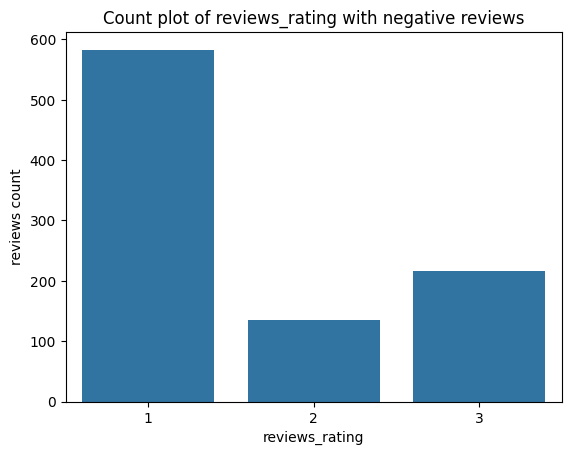

In [189]:
#sns.countplot(x = 'reviews_rating', data = review[review['user_sentiment']== 'Negative']).set(title="Count plot of reviews_rating with negative reviews", xlabel="reviews_rating", ylabel="reviews count")
#plt.show()

The columns name (product name) and user name are currently strings. It will be better for analysis if a numeric value is assigned to them. We can create a dictionary for all values in these columns and assign correspondings values to them.

In [283]:
# Creating a dictionary with all unique names mapped to a number
name_dict = uniq_dict(review,"name")
# Creating a dictionary with all unique usernames mapped to a number
user_dict = uniq_dict(review,"reviews_username")

No of unique values : 249
No of unique values : 24743


In [284]:
name_dict

{'Pink Friday: Roman Reloaded Re-Up (w/dvd)': 0,
 'Lundberg Organic Cinnamon Toast Rice Cakes': 1,
 'K-Y Love Sensuality Pleasure Gel': 2,
 'J.R. Watkins Hand Cream, Lemon Cream': 3,
 'Ambi Complexion Cleansing Bar': 4,
 "Johnson's Baby Bubble Bath and Wash, 15oz": 5,
 'Olay Regenerist Deep Hydration Regenerating Cream': 6,
 'Windex Original Glass Cleaner Refill 67.6oz (2 Liter)': 7,
 'Heinz Tomato Ketchup, 38oz': 8,
 'Kind Dark Chocolate Chunk Gluten Free Granola Bars - 5 Count': 9,
 'Pantene Color Preserve Volume Shampoo, 25.4oz': 10,
 'Aussie Aussome Volume Shampoo, 13.5 Oz': 11,
 "Cars Toon: Mater's Tall Tales": 12,
 'CeraVe SA Renewing Cream': 13,
 'Solo Foods Almond Paste': 14,
 'Finish Quantum Dishwasher Detergent, Lemon Sparkle Scent, 45 Count': 15,
 'Disney174 Jake And The Neverland Pirates 4 Piece Bedding Set - Toddler': 16,
 'Pearhead Id Bracelet Frame': 17,
 'Craft Punch Giga Scallop Circle 45 24687534 To 334': 18,
 'Neutrogena Wet Skin Sunscreen Spray Broad Spectrum SPF 50

In [285]:
user_dict

{'joshua': 0,
 'dorothy w': 1,
 'rebecca': 2,
 'walker557': 3,
 'samantha': 4,
 'raeanne': 5,
 'kimmie': 6,
 'cassie': 7,
 'moore222': 8,
 'jds1992': 9,
 'bre234': 10,
 'gordy313': 11,
 'nicole': 12,
 'cvperez': 13,
 'beccagrl532': 14,
 'sanchez': 15,
 'll24': 16,
 'browns fan': 17,
 'just faith everyday': 18,
 'vero': 19,
 'jo276': 20,
 'ashley a': 21,
 'jp71': 22,
 'jkell': 23,
 'karen': 24,
 'warren': 25,
 'mas0814': 26,
 'amanda': 27,
 'peach pie': 28,
 'birdwoman': 29,
 'michelle': 30,
 'jean z': 31,
 'vanessa mcnally': 32,
 '5alarm': 33,
 'danielle': 34,
 'shedove': 35,
 'cynthiacc': 36,
 'dfwatheartgirl': 37,
 'crissyx5': 38,
 'nyisha m': 39,
 'gardenbunny318': 40,
 'solo': 41,
 'sasparilla': 42,
 'mkris18': 43,
 'momof2': 44,
 'mommyshappy8714': 45,
 'eyo': 46,
 'anonymous8589': 47,
 'jazzymom': 48,
 'ramona831': 49,
 'morgiana': 50,
 'alnscoob97': 51,
 'star33': 52,
 'jacmary': 53,
 'mabelle': 54,
 'kayc': 55,
 'jen717': 56,
 'piggyboy420': 57,
 'darklin': 58,
 'docless82': 59

In [286]:
#Mapping the name column with its assigned numeric value
review = mapper(review,"name")
#Mapping the user name column with its assigned numeric value
review = mapper(review,"reviews_username")

name : 
No of unique values : 249
reviews_username : 
No of unique values : 24743


During review it was observed that for the same username and product we have reviews. This indicates for single product user has multiple reviews for a single product. These rows should be removed since it will cause issues during building recomendation system.

In [287]:
review['duplicate_review'] = review.duplicated(['reviews_username','name'])

In [288]:
review['duplicate_review'].value_counts()

False    27356
True      2344
Name: duplicate_review, dtype: int64

There are total of 2344 records which are duplicate reviews.

In [289]:
review[review['duplicate_review']==True].head()

id      brand  \
2   AV14LG0R-jtxr-f38QfS   Lundberg   
12  AV16khLE-jtxr-f38VFn        K-Y   
44  AV1h6Gu0glJLPUi8IjA_  Johnson's   
79  AV1l8zRZvKc47QAVhnAv       Olay   
90  AV1l8zRZvKc47QAVhnAv       Olay   

                                           categories  name  \
2   Food,Packaged Foods,Snacks,Crackers,Snacks, Co...     1   
12  Personal Care,Medicine Cabinet,Lubricant/Sperm...     2   
44  Personal Care,Baby Care,Baby Bubble Bath,Baby,...     5   
79  Personal Care,Skin Care,Anti-Aging,Beauty,Face...     6   
90  Personal Care,Skin Care,Anti-Aging,Beauty,Face...     6   

                reviews_date  reviews_rating  \
2  2017-07-09 00:00:00+00:00               5   
12 2016-04-08 00:00:00+00:00               1   
44 2017-05-09 00:00:00+00:00               4   
79 2016-04-30 00:00:00+00:00               3   
90 2016-04-30 03:08:38+00:00               3   

                                         reviews_text  \
2                                        Good flavor.   
12  Bought this to enhance our time a bit, did abs...   
44  Well, Johnson's need I say more I know, right....   
79  Today is my first time using this product. Fel...   
90  Today is my first time using this product. Fel...   

                    reviews_title  reviews_username user_sentiment  \
2                            Good                 1       Positive   
12                 waste of money                 9       Negative   
44                      2 in 1!!!                41       Positive   
79  Why No fragrance-free Formula                64       Positive   
90  Why No Fragrance-free Formula                64       Positive   

    Promotional_Reviews  duplicate_review  
2                     0              True  
12                    0              True  
44                    0              True  
79                    0              True  
90                    0              True

In [290]:
review.loc[(review['name'] == 1) & (review['reviews_username'] == 1)]

id     brand  \
1  AV14LG0R-jtxr-f38QfS  Lundberg   
2  AV14LG0R-jtxr-f38QfS  Lundberg   

                                          categories  name  \
1  Food,Packaged Foods,Snacks,Crackers,Snacks, Co...     1   
2  Food,Packaged Foods,Snacks,Crackers,Snacks, Co...     1   

               reviews_date  reviews_rating  \
1 2017-07-09 00:00:00+00:00               5   
2 2017-07-09 00:00:00+00:00               5   

                                        reviews_text reviews_title  \
1  Good flavor. This review was collected as part...          Good   
2                                       Good flavor.          Good   

   reviews_username user_sentiment  Promotional_Reviews  duplicate_review  
1                 1       Positive                    1             False  
2                 1       Positive                    0              True

In [291]:
review.loc[(review['name'] == 5) & (review['reviews_username'] == 41)]

id      brand  \
43  AV1h6Gu0glJLPUi8IjA_  Johnson's   
44  AV1h6Gu0glJLPUi8IjA_  Johnson's   

                                           categories  name  \
43  Personal Care,Baby Care,Baby Bubble Bath,Baby,...     5   
44  Personal Care,Baby Care,Baby Bubble Bath,Baby,...     5   

                reviews_date  reviews_rating  \
43 2017-05-09 07:36:44+00:00               4   
44 2017-05-09 00:00:00+00:00               4   

                                         reviews_text reviews_title  \
43  Well, Johnson's need I say more I know, right....     2 In 1!!!   
44  Well, Johnson's need I say more I know, right....     2 in 1!!!   

    reviews_username user_sentiment  Promotional_Reviews  duplicate_review  
43                41       Positive                    0             False  
44                41       Positive                    0              True

Here we can see that there is a clear indication of duplication for user 1 and 41.

In [292]:
#We are removing the duplicated rows keeping the records with max rating
review = duplicate_remove(review,'max')

In [293]:
review.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27356 entries, 0 to 29999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   id                   27356 non-null  string             
 1   brand                27356 non-null  string             
 2   categories           27356 non-null  string             
 3   name                 27356 non-null  int64              
 4   reviews_date         27356 non-null  datetime64[ns, UTC]
 5   reviews_rating       27356 non-null  Int64              
 6   reviews_text         27356 non-null  string             
 7   reviews_title        27356 non-null  string             
 8   reviews_username     27356 non-null  int64              
 9   user_sentiment       27356 non-null  string             
 10  Promotional_Reviews  27356 non-null  int64              
dtypes: Int64(1), datetime64[ns, UTC](1), int64(3), string(6)
memory usage: 2.5 MB


In [294]:
isnull(review)

Empty DataFrame
Columns: [nullcount, nullpercent]
Index: []

Splitting the data for train and test

In [295]:
train, test = train_test_split(review, test_size=0.30, random_state=101)

In [296]:
# Getting a copy of dataframe for pre-processing
train_modeling = train.copy()

In [297]:
train_modeling['reviews_combined'] = train_modeling['reviews_text'] + " " + train_modeling['reviews_title']
train_modeling.drop(columns=['reviews_text', 'reviews_title'], inplace=True)

In [298]:
train_modeling.head()

id              brand  \
18833  AVpfJP1C1cnluZ0-e3Xy             Clorox   
24457  AVpfPaoqLJeJML435Xk9  Warner Home Video   
11662  AVpf3VOfilAPnD_xjpun             Clorox   
11217  AVpf3VOfilAPnD_xjpun             Clorox   
11849  AVpf3VOfilAPnD_xjpun             Clorox   

                                              categories  name  \
18833  Household Chemicals,Household Cleaners,Bath & ...   167   
24457  Movies, Music & Books,Movies,Action & Adventur...   209   
11662  Household Essentials,Cleaning Supplies,Kitchen...    84   
11217  Household Essentials,Cleaning Supplies,Kitchen...    84   
11849  Household Essentials,Cleaning Supplies,Kitchen...    84   

                   reviews_date  reviews_rating  reviews_username  \
18833 2012-01-22 23:07:39+00:00               4             16655   
24457 2014-09-19 00:00:00+00:00               4             20421   
11662 2012-01-26 00:00:00+00:00               5             10610   
11217 2015-01-10 00:00:00+00:00               5             10228   
11849 2015-02-26 00:00:00+00:00               5             10776   

      user_sentiment  Promotional_Reviews  \
18833       Positive                    0   
24457       Positive                    0   
11662       Positive                    0   
11217       Positive                    1   
11849       Positive                    1   

                                        reviews_combined  
18833  It really did what it was suppost to. a whole ...  
24457  very very good remake of a classic horror movi...  
11662  I have this in the drawer next to each toilet ...  
11217  We us clorox wipes all the time to keep our ki...  
11849  They are perfect for any and all messes, espec...

For sentiment analysis we only need the reviews combined,sentiment,id column.Other columns can be droped.

In [299]:
train_modeling.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19149 entries, 18833 to 14092
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   id                   19149 non-null  string             
 1   brand                19149 non-null  string             
 2   categories           19149 non-null  string             
 3   name                 19149 non-null  int64              
 4   reviews_date         19149 non-null  datetime64[ns, UTC]
 5   reviews_rating       19149 non-null  Int64              
 6   reviews_username     19149 non-null  int64              
 7   user_sentiment       19149 non-null  string             
 8   Promotional_Reviews  19149 non-null  int64              
 9   reviews_combined     19149 non-null  string             
dtypes: Int64(1), datetime64[ns, UTC](1), int64(3), string(5)
memory usage: 1.6 MB


In [300]:
#train_modeling.drop(columns=['categories', 'reviews_date','Promotional_Reviews','brand','reviews_rating'], inplace=True)
train_modeling = train_modeling[['id','reviews_combined','user_sentiment']]

In [301]:
train_modeling.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19149 entries, 18833 to 14092
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                19149 non-null  string
 1   reviews_combined  19149 non-null  string
 2   user_sentiment    19149 non-null  string
dtypes: string(3)
memory usage: 598.4 KB


In [302]:
clean_lemma("hello asking who cars are asked")

'hello ask who car be ask'

In [303]:
train_modeling['reviews_preprocessed']=train_modeling.reviews_combined.apply(lambda x: text_preprocessing(x) )

In [304]:
train_modeling.head()

id  \
18833  AVpfJP1C1cnluZ0-e3Xy   
24457  AVpfPaoqLJeJML435Xk9   
11662  AVpf3VOfilAPnD_xjpun   
11217  AVpf3VOfilAPnD_xjpun   
11849  AVpf3VOfilAPnD_xjpun   

                                        reviews_combined user_sentiment  \
18833  It really did what it was suppost to. a whole ...       Positive   
24457  very very good remake of a classic horror movi...       Positive   
11662  I have this in the drawer next to each toilet ...       Positive   
11217  We us clorox wipes all the time to keep our ki...       Positive   
11849  They are perfect for any and all messes, espec...       Positive   

                                    reviews_preprocessed  
18833  really suppost whole bathroom cleaner one toli...  
24457  good remake classic horror movie better expect...  
11662  drawer next toilet house quickly disinfect cle...  
11217  us clorox wipes time keep kitchen clean clean ...  
11849  perfect messes especially convenient dog cat t...

In [305]:
train_modeling['reviews_lemmatised']=train_modeling.reviews_combined.apply(lambda x: clean_lemma(x) )

In [306]:
train_modeling.head()

id  \
18833  AVpfJP1C1cnluZ0-e3Xy   
24457  AVpfPaoqLJeJML435Xk9   
11662  AVpf3VOfilAPnD_xjpun   
11217  AVpf3VOfilAPnD_xjpun   
11849  AVpf3VOfilAPnD_xjpun   

                                        reviews_combined user_sentiment  \
18833  It really did what it was suppost to. a whole ...       Positive   
24457  very very good remake of a classic horror movi...       Positive   
11662  I have this in the drawer next to each toilet ...       Positive   
11217  We us clorox wipes all the time to keep our ki...       Positive   
11849  They are perfect for any and all messes, espec...       Positive   

                                    reviews_preprocessed  \
18833  really suppost whole bathroom cleaner one toli...   
24457  good remake classic horror movie better expect...   
11662  drawer next toilet house quickly disinfect cle...   
11217  us clorox wipes time keep kitchen clean clean ...   
11849  perfect messes especially convenient dog cat t...   

                                      reviews_lemmatised  
18833  it really do what it be suppost to . a whole b...  
24457  very very good remake of a classic horror movi...  
11662  I have this in the drawer next to each toilet ...  
11217  we we clorox wipe all the time to keep our kit...  
11849  they be perfect for any and all mess , especia...

In [307]:
train_modeling.to_csv(r'/content/drive/MyDrive/sentiment-based product recommendation system/reviewslemmatised.csv', index=False)

In [308]:
train_modeling = fileopen("/content/drive/MyDrive/sentiment-based product recommendation system/reviewslemmatised.csv")

In [309]:
train_modeling.head()

id                                   reviews_combined  \
0  AVpfJP1C1cnluZ0-e3Xy  It really did what it was suppost to. a whole ...   
1  AVpfPaoqLJeJML435Xk9  very very good remake of a classic horror movi...   
2  AVpf3VOfilAPnD_xjpun  I have this in the drawer next to each toilet ...   
3  AVpf3VOfilAPnD_xjpun  We us clorox wipes all the time to keep our ki...   
4  AVpf3VOfilAPnD_xjpun  They are perfect for any and all messes, espec...   

  user_sentiment                               reviews_preprocessed  \
0       Positive  really suppost whole bathroom cleaner one toli...   
1       Positive  good remake classic horror movie better expect...   
2       Positive  drawer next toilet house quickly disinfect cle...   
3       Positive  us clorox wipes time keep kitchen clean clean ...   
4       Positive  perfect messes especially convenient dog cat t...   

                                  reviews_lemmatised  
0  it really do what it be suppost to . a whole b...  
1  very very good remake of a classic horror movi...  
2  I have this in the drawer next to each toilet ...  
3  we we clorox wipe all the time to keep our kit...  
4  they be perfect for any and all mess , especia...

Feature extraction using Tfidf.

In [310]:
# Initialize the TfidfVectorizer
tfidf = TfidfVectorizer(min_df=5, max_df=0.95, stop_words='english', ngram_range=(1,2))

In [311]:
X = tfidf.fit_transform(train_modeling['reviews_lemmatised'])

y= train_modeling['user_sentiment']

In [312]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)

In [313]:
print("Train shapes:", X_train.shape, y_train.shape)
print("Test shapes:", X_test.shape, y_test.shape)

Train shapes: (14361, 10542) (14361,)
Test shapes: (4788, 10542) (4788,)


In [314]:
# Check the data to see if there is a class imbalance in the data
train_modeling['user_sentiment'].value_counts(normalize=True)

Positive    0.890073
Negative    0.109927
Name: user_sentiment, dtype: float64

There is a high class imbalance. We can address this issue by creating sythetic data using SMOTE method

In [315]:
counter = Counter(y_train)
print("Before handling imbalance", counter)

#oversampling using SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train,y_train)

counter = Counter(y_train_sm)
print("After handling imbalance", counter)

Before handling imbalance Counter({'Positive': 12739, 'Negative': 1622})
After handling imbalance Counter({'Positive': 12739, 'Negative': 12739})


<Axes: xlabel='user_sentiment', ylabel='Count'>

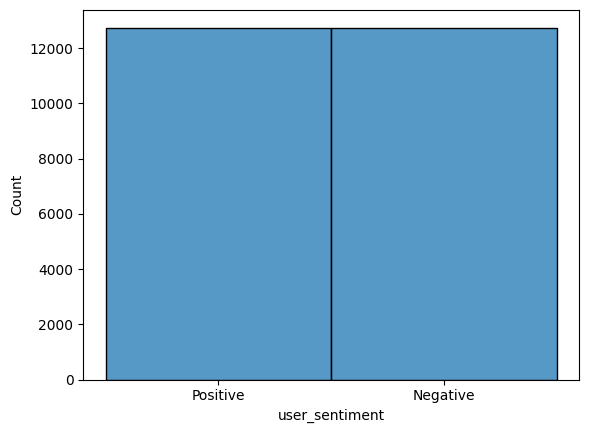

In [316]:
sns.histplot(y_train_sm)

# Modeling

In [317]:
  now = datetime.now()
  print(now)

2024-03-17 11:42:13.770641


In [318]:
logreg = LogisticRegression(random_state=42, solver='liblinear').fit(X_train_sm, y_train_sm)

Visualizing the Confusion Matrix with a Heatmap


**************************************************


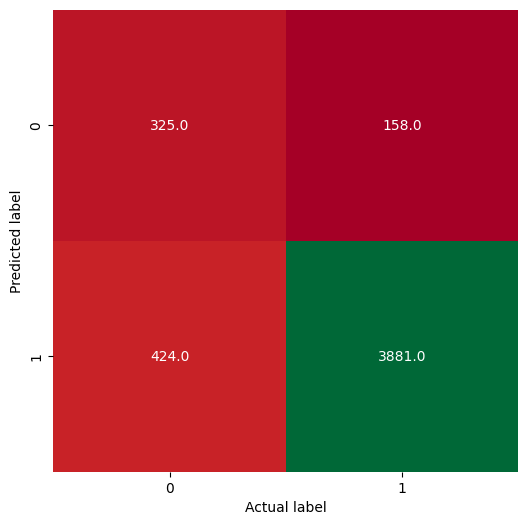

**************************************************


Values of True Positives, True Negatives, False Positivies and False Negatives
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True Positives: 3881
True Negatives: 325
False Positives: 158
False Negatives: 424
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Evaluation Score Summary
--------------------------------------------------
Accuracy Score: 0.88
Sensitivity/Recall Score: 0.9
Specificity Score: 0.67
Precision: 0.96
F1 Score: 0.93
--------------------------------------------------


In [319]:
# Getting the score of the base model
lr_metrics = evaluation_scores(logreg, X_test, y_test)

In [320]:
store_model(logreg,"logistic_regression")

In [321]:
logreg_grid = {"C": [100, 10, 5, 4, 3, 2, 1, 1.0, 0.1, 0.01],
                "solver": ["liblinear"]}

In [322]:
# Setup grid hyperparameter search for LogisticRegression
logreg_hpt = GridSearchCV(LogisticRegression(random_state=42),
                                param_grid=logreg_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1,
                                scoring='f1')

# Fit random hyperparameter search model
logreg_hpt.fit(X_train_sm, y_train_sm);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [323]:
# Checking the best parameters
logreg_hpt.best_params_

{'C': 100, 'solver': 'liblinear'}

Visualizing the Confusion Matrix with a Heatmap


**************************************************


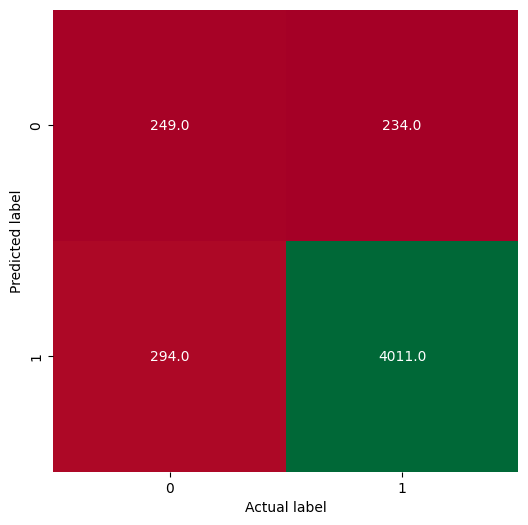

**************************************************


Values of True Positives, True Negatives, False Positivies and False Negatives
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True Positives: 4011
True Negatives: 249
False Positives: 234
False Negatives: 294
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Evaluation Score Summary
--------------------------------------------------
Accuracy Score: 0.89
Sensitivity/Recall Score: 0.93
Specificity Score: 0.52
Precision: 0.94
F1 Score: 0.93
--------------------------------------------------


In [324]:
# Getting the scores of the tuned model
lr_tuned_metrics = evaluation_scores(logreg_hpt, X_test, y_test)

In [325]:
store_model(logreg_hpt,"logistic_regression_tuned")

Random Forest classifier

In [326]:
rf = RandomForestClassifier(random_state=42).fit(X_train_sm, y_train_sm)

Visualizing the Confusion Matrix with a Heatmap


**************************************************


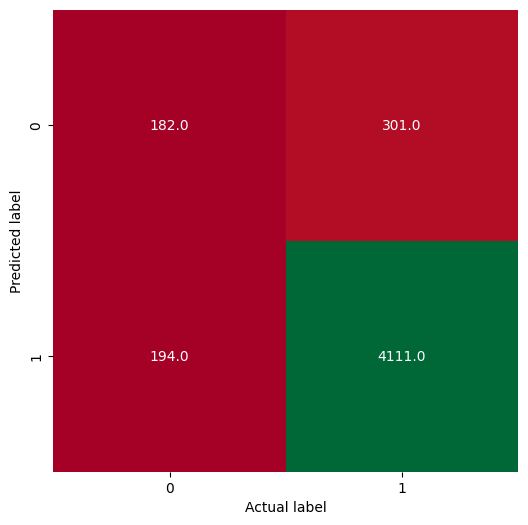

**************************************************


Values of True Positives, True Negatives, False Positivies and False Negatives
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True Positives: 4111
True Negatives: 182
False Positives: 301
False Negatives: 194
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Evaluation Score Summary
--------------------------------------------------
Accuracy Score: 0.9
Sensitivity/Recall Score: 0.95
Specificity Score: 0.38
Precision: 0.93
F1 Score: 0.94
--------------------------------------------------


In [327]:
# Getting the score of the base model
rf_metrics = evaluation_scores(rf, X_test, y_test)

In [328]:
store_model(rf,"random_forest")

In [329]:
rf_grid = {"n_estimators": np.arange(10, 1000, 50),
           "max_depth": np.arange(10, 50, 5),
           "min_samples_split": np.arange(15, 500, 15),
           "min_samples_leaf": np.arange(5, 50, 5)}
# Setup random hyperparameter search for Random Forest Classifier
rf_hpt = RandomizedSearchCV(RandomForestClassifier(random_state=42),
                                param_distributions=rf_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1,
                                scoring='f1')

# Fit random hyperparameter search model
rf_hpt.fit(X_train_sm, y_train_sm);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [330]:
# Check best parameters
rf_hpt.best_params_

{'n_estimators': 460,
 'min_samples_split': 405,
 'min_samples_leaf': 5,
 'max_depth': 45}

Visualizing the Confusion Matrix with a Heatmap


**************************************************


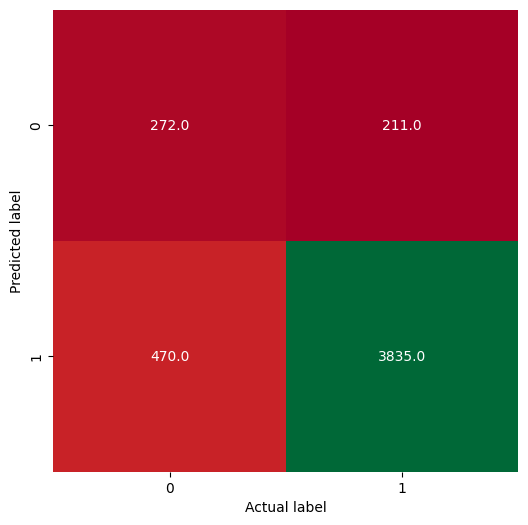

**************************************************


Values of True Positives, True Negatives, False Positivies and False Negatives
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True Positives: 3835
True Negatives: 272
False Positives: 211
False Negatives: 470
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Evaluation Score Summary
--------------------------------------------------
Accuracy Score: 0.86
Sensitivity/Recall Score: 0.89
Specificity Score: 0.56
Precision: 0.95
F1 Score: 0.92
--------------------------------------------------


[0.86, 0.89, 0.56, 0.95, 0.92]

In [331]:
evaluation_scores(rf_hpt, X_test, y_test)

In [332]:
store_model(rf_hpt,"random_forest_random_tuned")

In [333]:
# Fine tuning using Grid Search CV
rf_grid = {"n_estimators": [510],
           "max_depth": [20],
           "min_samples_split": [350, 400],
           "min_samples_leaf": [45, 50]}

In [334]:
# Setup random hyperparameter search for Random Forest Classifier
rf_hpt = GridSearchCV(RandomForestClassifier(random_state=42),
                                param_grid=rf_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1,
                                scoring='f1')

# Fit random hyperparameter search model
rf_hpt.fit(X_train_sm, y_train_sm)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [20], 'min_samples_leaf': [45, 50],
                         'min_samples_split': [350, 400],
                         'n_estimators': [510]},
             scoring='f1', verbose=True)

Visualizing the Confusion Matrix with a Heatmap


**************************************************


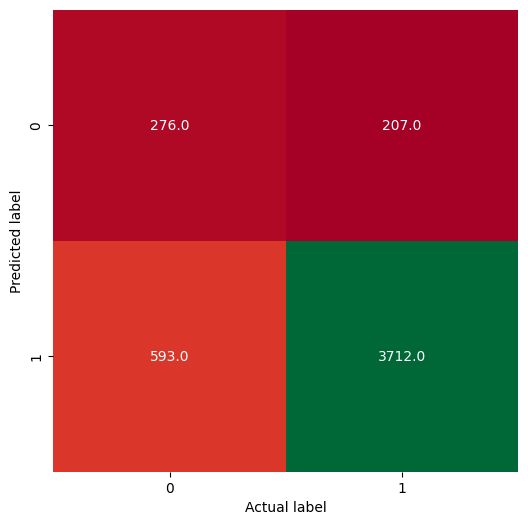

**************************************************


Values of True Positives, True Negatives, False Positivies and False Negatives
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True Positives: 3712
True Negatives: 276
False Positives: 207
False Negatives: 593
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Evaluation Score Summary
--------------------------------------------------
Accuracy Score: 0.83
Sensitivity/Recall Score: 0.86
Specificity Score: 0.57
Precision: 0.95
F1 Score: 0.9
--------------------------------------------------


In [335]:
# Getting the scores of the tuned model
rf_tuned_metrics = evaluation_scores(rf_hpt, X_test, y_test)

In [336]:
store_model(rf_hpt,"random_forest_grid_tuned")

xgboost

In [337]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_train_sm)

xg = xgb.XGBClassifier(random_state=42).fit(X_train_sm, y_encoded)

Visualizing the Confusion Matrix with a Heatmap


**************************************************


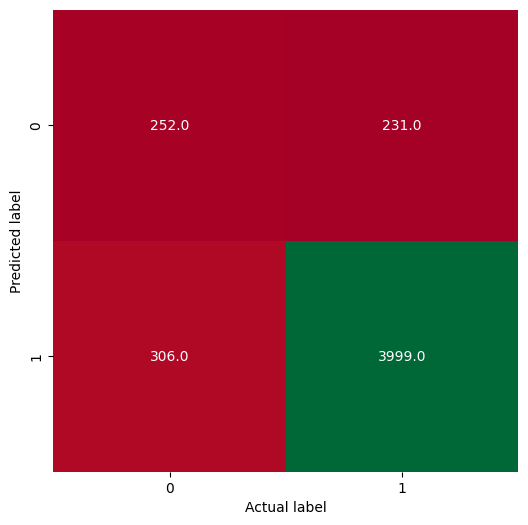

**************************************************


Values of True Positives, True Negatives, False Positivies and False Negatives
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True Positives: 3999
True Negatives: 252
False Positives: 231
False Negatives: 306
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Evaluation Score Summary
--------------------------------------------------
Accuracy Score: 0.89
Sensitivity/Recall Score: 0.93
Specificity Score: 0.52
Precision: 0.95
F1 Score: 0.94
--------------------------------------------------


In [338]:
# Getting the score of the base model

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_test)

xg_metrics = evaluation_scores(xg, X_test, y_encoded)

In [339]:
store_model(xg,"xg_boost")

In [340]:
xg_grid = {"learning_rate": np.arange(0.05, 1, 0.1),
           "max_depth": np.arange(5, 20, 5)
           }

In [341]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_train_sm)

# Setup random hyperparameter search for Random Forest Classifier
xg_hpt = RandomizedSearchCV(XGBClassifier(random_state=42),
                                param_distributions=xg_grid,
                                cv=4,
                                verbose=True,
                                n_jobs=-1,
                                scoring='f1')

# Fit random hyperparameter search model
xg_hpt.fit(X_train_sm, y_encoded);

Fitting 4 folds for each of 10 candidates, totalling 40 fits


In [342]:
# Check best parameters
xg_hpt.best_params_

{'max_depth': 15, 'learning_rate': 0.7500000000000002}

Visualizing the Confusion Matrix with a Heatmap


**************************************************


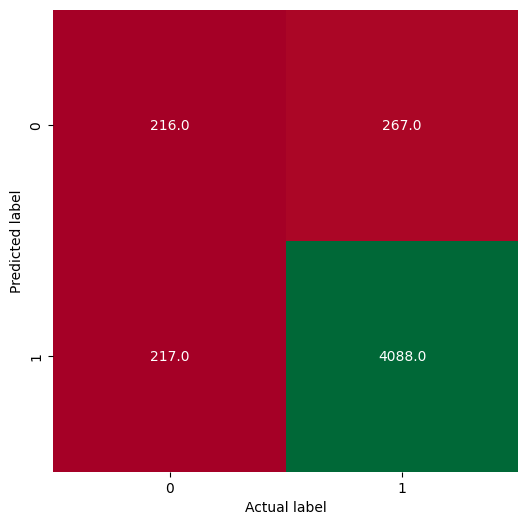

**************************************************


Values of True Positives, True Negatives, False Positivies and False Negatives
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True Positives: 4088
True Negatives: 216
False Positives: 267
False Negatives: 217
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Evaluation Score Summary
--------------------------------------------------
Accuracy Score: 0.9
Sensitivity/Recall Score: 0.95
Specificity Score: 0.45
Precision: 0.94
F1 Score: 0.94
--------------------------------------------------


[0.9, 0.95, 0.45, 0.94, 0.94]

In [343]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_test)

evaluation_scores(xg_hpt, X_test, y_encoded)

In [344]:
store_model(xg_hpt,"xg_boost_random_tuned")

In [345]:
# Fine tuning with Grid Search CV
xg_grid = {"learning_rate": [0.45, 0.15],
           "max_depth": [5, 10]
           }

In [346]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_train_sm)

# Setup random hyperparameter search for Random Forest Classifier
xg_hpt = GridSearchCV(XGBClassifier(random_state=42),
                                param_grid=xg_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1,
                                scoring='f1')

# Fit random hyperparameter search model
xg_hpt.fit(X_train_sm, y_encoded);

Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [347]:
# Check best parameters
xg_hpt.best_params_

{'learning_rate': 0.45, 'max_depth': 10}

Visualizing the Confusion Matrix with a Heatmap


**************************************************


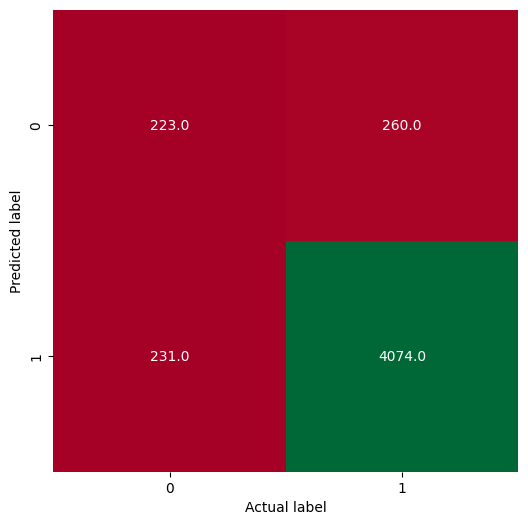

**************************************************


Values of True Positives, True Negatives, False Positivies and False Negatives
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True Positives: 4074
True Negatives: 223
False Positives: 260
False Negatives: 231
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Evaluation Score Summary
--------------------------------------------------
Accuracy Score: 0.9
Sensitivity/Recall Score: 0.95
Specificity Score: 0.46
Precision: 0.94
F1 Score: 0.94
--------------------------------------------------


In [348]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_test)

# Getting the scores of the tuned model
xg_tuned_metrics = evaluation_scores(xg_hpt, X_test, y_encoded)

In [349]:
store_model(xg_hpt,"xg_boost_grid_tuned")

# Recomendation system

## Using user similarity

In [350]:
review_filtered =  train[['reviews_username','name','reviews_rating']]

In [351]:
# Pivot the train ratings' dataset into matrix format in which columns are movies and the rows are user IDs.
df_pivot = review_filtered.pivot(
    index='reviews_username',
    columns='name',
    values='reviews_rating'
).fillna(0)

df_pivot.head(5)

name              0    1    2    3    4    5    6    7    8    9    ...  237  \
reviews_username                                                    ...        
0                   5    0    0    0    0    0    0    0    0    0  ...    0   
1                   0    5    0    0    0    0    0    0    0    0  ...    0   
2                   0    0    1    0    0    0    0    0    0    0  ...    0   
4                   0    0    1    0    0    0    0    0    0    0  ...    0   
6                   0    0    1    0    0    0    0    0    0    0  ...    0   

name              238  239  242  243  244  245  246  247  248  
reviews_username                                               
0                   0    0    0    0    0    0    0    0    0  
1                   0    0    0    0    0    0    0    0    0  
2                   0    0    0    0    0    0    0    5    0  
4                   0    0    0    0    0    0    0    0    0  
6                   0    0    0    0    0    0    0    0    0  

[5 rows x 229 columns]

In [352]:
# Copy the train dataset into dummy_train
dummy_train = review_filtered.copy()

In [353]:
# The movies not rated by user is marked as 1 for prediction.
dummy_train['reviews_rating'] = dummy_train['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)

In [354]:
# Convert the dummy train dataset into matrix format.
dummy_train = dummy_train.pivot(
    index='reviews_username',
    columns='name',
    values='reviews_rating'
).fillna(1)

In [355]:
dummy_train.head()

name              0    1    2    3    4    5    6    7    8    9    ...  237  \
reviews_username                                                    ...        
0                 0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0   
1                 1.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0   
2                 1.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0   
4                 1.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0   
6                 1.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0   

name              238  239  242  243  244  245  246  247  248  
reviews_username                                               
0                 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  
1                 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  
2                 1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  1.0  
4                 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  
6                 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  

[5 rows x 229 columns]

### Normalising the rating of the movie for each user around 0 mean

In [356]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

In [357]:
df_subtracted.head()

name                   0         1         2         3         4         5    \
reviews_username                                                               
0                 4.925764 -0.074236 -0.074236 -0.074236 -0.074236 -0.074236   
1                -0.021834  4.978166 -0.021834 -0.021834 -0.021834 -0.021834   
2                -0.048035 -0.048035  0.951965 -0.048035 -0.048035 -0.048035   
4                -0.026201 -0.026201  0.973799 -0.026201 -0.026201 -0.026201   
6                -0.043668 -0.043668  0.956332 -0.043668 -0.043668 -0.043668   

name                   6         7         8         9    ...       237  \
reviews_username                                          ...             
0                -0.074236 -0.074236 -0.074236 -0.074236  ... -0.074236   
1                -0.021834 -0.021834 -0.021834 -0.021834  ... -0.021834   
2                -0.048035 -0.048035 -0.048035 -0.048035  ... -0.048035   
4                -0.026201 -0.026201 -0.026201 -0.026201  ... -0.026201   
6                -0.043668 -0.043668 -0.043668 -0.043668  ... -0.043668   

name                   238       239       242       243       244       245  \
reviews_username                                                               
0                -0.074236 -0.074236 -0.074236 -0.074236 -0.074236 -0.074236   
1                -0.021834 -0.021834 -0.021834 -0.021834 -0.021834 -0.021834   
2                -0.048035 -0.048035 -0.048035 -0.048035 -0.048035 -0.048035   
4                -0.026201 -0.026201 -0.026201 -0.026201 -0.026201 -0.026201   
6                -0.043668 -0.043668 -0.043668 -0.043668 -0.043668 -0.043668   

name                   246       247       248  
reviews_username                                
0                -0.074236 -0.074236 -0.074236  
1                -0.021834 -0.021834 -0.021834  
2                -0.048035  4.951965 -0.048035  
4                -0.026201 -0.026201 -0.026201  
6                -0.043668 -0.043668 -0.043668  

[5 rows x 229 columns]

### Finding cosine similarity

In [358]:
# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[ 1.         -0.00866399 -0.01338557 ... -0.00866399 -0.00866399
  -0.00866399]
 [-0.00866399  1.         -0.00677616 ... -0.00438596 -0.00438596
  -0.00438596]
 [-0.01338557 -0.00677616  1.         ... -0.00677616 -0.00677616
  -0.00677616]
 ...
 [-0.00866399 -0.00438596 -0.00677616 ...  1.          1.
   1.        ]
 [-0.00866399 -0.00438596 -0.00677616 ...  1.          1.
   1.        ]
 [-0.00866399 -0.00438596 -0.00677616 ...  1.          1.
   1.        ]]


### Prediction - User User

Doing the prediction for the users which are positively related with other users, and not the users which are negatively related as we are interested in the users which are more similar to the current users. So, ignoring the correlation for values less than 0.

In [359]:
user_correlation[user_correlation<0]=0
user_correlation

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]])

In [ ]:
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_predicted_ratings

In [ ]:
user_predicted_ratings.shape

In [ ]:
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

In [ ]:
# Take the user ID as input.
user_input = int(input("Enter your user name"))
for key, value in user_dict.items():
    if value == user_input:
        user = key
        break
print("For user {}. {} \n The recomended items are : \n".format(user_input,user))
d = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
for key, value in name_dict.items():
    if value in d.index:
        print(key)

In [ ]:
user_final_rating.to_csv(r'/content/drive/MyDrive/sentiment-based product recommendation system/user_final_rating.csv', index=False)

In [ ]:
d = user_final_rating.loc[user_input].sort_values(ascending=False)[0:5]
d.index

Int64Index([183, 90, 228, 223, 114], dtype='int64', name='name')

In [ ]:
for key, value in name_dict.items():
    if value in d.index:
        print(key)

Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total
Just For Men Touch Of Gray Gray Hair Treatment, Black T-55
Clorox Disinfecting Bathroom Cleaner
Clear Scalp & Hair Therapy Total Care Nourishing Shampoo
Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd


### Evaluation - User User

Evaluation will we same as you have seen above for the prediction. The only difference being, you will evaluate for the movie already rated by the user insead of predicting it for the movie not rated by the user.

In [ ]:
test.shape

(8282, 15)

In [ ]:
name_dict_test = uniq_dict(test,"name")
user_dict_test = uniq_dict(test,"reviews_username")
review_test = mapper(test,"name")
review_test = mapper(test,"reviews_username")

No of unique values : 219
No of unique values : 7930
name : 
No of unique values : 219
reviews_username : 
No of unique values : 7930


In [ ]:
# Find out the common users of test and train dataset.
common = review_test[review_test.reviews_username.isin(train.reviews_username)].copy()
common.shape

(6020, 15)

In [ ]:
common.head()

id        brand  \
16010  AVpf63aJLJeJML43F__Q  Burt's Bees   
16749  AVpf7LysilAPnD_xkm9G    Cuisinart   
18108  AVpfD9xTLJeJML431ig2          FOX   
13005  AVpf3VOfilAPnD_xjpun       Clorox   
6301   AVpf385g1cnluZ0-s0_t       Hormel   

                                              categories      manufacturer  \
16010  Personal Care,Makeup,Lipstick, Lip Gloss, & Li...       Burt's Bees   
16749  Kitchen & Dining,Kitchen Appliances,Juicers,Ap...         CUISINART   
18108  Movies, Music & Books,Movies,Comedy,Movies & T...  20th Century Fox   
13005  Household Essentials,Cleaning Supplies,Kitchen...            Clorox   
6301   Food,Packaged Foods,Canned Foods,Canned Meals,...            Hormel   

       name              reviews_date reviews_didPurchase reviews_doRecommend  \
16010     0  2014-10-01T00:00:00.000Z               False                True   
16749     1  2017-04-29T00:00:00.000Z                 NaN                True   
18108     2  2014-12-18T00:00:00.000Z                 NaN                True   
13005     4  2012-01-28T00:00:00.000Z               False                True   
6301      6  2016-03-09T00:00:00.000Z               False                True   

       reviews_rating                                       reviews_text  \
16010               5  I love this to reapply all throughout the day....   
16749               5  Great*****************************************...   
18108               4  Entertaining but not for kids. My wife was Mag...   
13005               5  I absolutely love this product, and use it dai...   
6301                4          Meal in a can, very good, I will buy more   

         reviews_title reviews_userCity reviews_userProvince  \
16010  Great chapstick              NaN                  NaN   
16749            Great              NaN                  NaN   
18108      Funny Movie              NaN                  NaN   
13005        Love it!!              NaN                  NaN   
6301             Chili              NaN                  NaN   

       reviews_username user_sentiment  
16010                 0       Positive  
16749                 1       Positive  
18108                 2       Positive  
13005                 4       Positive  
6301                  6       Positive

In [ ]:
# convert into the user-movie matrix.
common_user_based_matrix = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating')

In [ ]:
# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_correlation)

In [ ]:
df_subtracted.head(1)

name                   0         1         2         3         4         5    \
reviews_username                                                               
0                 4.928854 -0.071146 -0.071146 -0.071146 -0.071146 -0.071146   

name                   6         7         8         9    ...       261  \
reviews_username                                          ...             
0                -0.071146 -0.071146 -0.071146 -0.071146  ... -0.071146   

name                   262       263       264       265       266       267  \
reviews_username                                                               
0                -0.071146 -0.071146 -0.071146 -0.071146 -0.071146 -0.071146   

name                   268       269       270  
reviews_username                                
0                -0.071146 -0.071146 -0.071146  

[1 rows x 253 columns]

In [ ]:
user_correlation_df['reviews_username'] = df_subtracted.index
user_correlation_df.set_index('reviews_username',inplace=True)
user_correlation_df.head()

0      1         2         3         4         5      \
reviews_username                                                         
0                   1.0    0.0  0.000000  0.000000  0.000000  0.000000   
1                   0.0    1.0  0.000000  0.000000  0.000000  0.000000   
2                   0.0    0.0  1.000000  0.001228  0.014282  0.092225   
4                   0.0    0.0  0.001228  1.000000  0.026782  0.134839   
6                   0.0    0.0  0.014282  0.026782  1.000000  0.238909   

                     6         7         8         9      ...  17856  17857  \
reviews_username                                          ...                 
0                 0.000000  0.000000  0.000000  0.000000  ...    0.0    0.0   
1                 0.000000  0.000000  0.000000  0.000000  ...    0.0    0.0   
2                 0.092225  0.092225  0.000000  0.092225  ...    0.0    0.0   
4                 0.134839  0.134839  0.004945  0.134839  ...    0.0    0.0   
6                 0.238909  0.238909  0.019207  0.238909  ...    0.0    0.0   

                  17858  17859  17860  17861  17862  17863  17864  17865  
reviews_username                                                          
0                   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
1                   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
2                   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
4                   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
6                   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  

[5 rows x 17866 columns]

In [ ]:
list_name = common.reviews_username.tolist()

user_correlation_df.columns = df_subtracted.index.tolist()


user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]

In [ ]:
review_test.head(1)

id        brand  \
16010  AVpf63aJLJeJML43F__Q  Burt's Bees   

                                              categories manufacturer  name  \
16010  Personal Care,Makeup,Lipstick, Lip Gloss, & Li...  Burt's Bees     0   

                   reviews_date reviews_didPurchase reviews_doRecommend  \
16010  2014-10-01T00:00:00.000Z               False                True   

       reviews_rating                                       reviews_text  \
16010               5  I love this to reapply all throughout the day....   

         reviews_title reviews_userCity reviews_userProvince  \
16010  Great chapstick              NaN                  NaN   

       reviews_username user_sentiment  
16010                 0       Positive

In [ ]:
user_correlation_df_1.shape

(5750, 17866)

In [ ]:
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]

In [ ]:
user_correlation_df_3 = user_correlation_df_2.T

In [ ]:
user_correlation_df_3.head()

0     1         2         4         6         8     \
reviews_username                                                       
0                  1.0   0.0  0.000000  0.000000  0.000000  0.000000   
1                  0.0   1.0  0.000000  0.000000  0.000000  0.000000   
2                  0.0   0.0  1.000000  0.001228  0.014282  0.092225   
4                  0.0   0.0  0.001228  1.000000  0.026782  0.134839   
6                  0.0   0.0  0.014282  0.026782  1.000000  0.238909   

                      10        11        12        13    ...      7916  \
reviews_username                                          ...             
0                 0.000000  0.000000  0.000000  0.000000  ...  0.000000   
1                 0.000000  0.000000  0.000000  0.000000  ...  0.000000   
2                 0.092225  0.092225  0.000000  0.092225  ...  0.494515   
4                 0.134839  0.134839  0.004945  0.134839  ...  0.000000   
6                 0.238909  0.238909  0.019207  0.238909  ...  0.000000   

                      7918      7919      7920      7922      7923      7926  \
reviews_username                                                               
0                 0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1                 0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2                 0.494515  0.494515  0.494515  0.494515  0.494515  0.494515   
4                 0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
6                 0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

                      7927      7928      7929  
reviews_username                                
0                 0.000000  0.000000  0.000000  
1                 0.000000  0.000000  0.000000  
2                 0.494515  0.494515  0.494515  
4                 0.000000  0.000000  0.000000  
6                 0.000000  0.000000  0.000000  

[5 rows x 5750 columns]

In [ ]:
user_correlation_df_3.shape

(5750, 5750)

In [ ]:
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='reviews_username', columns='name', values='reviews_rating').fillna(0)

In [ ]:
user_correlation_df_3[user_correlation_df_3<0]=0

common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

array([[  9.51733304,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   5.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [101.09806073,  14.8668522 ,  14.62355054, ...,   2.96708993,
          2.96708993,   2.47257494],
       ...,
       [201.28814672,  30.11401556,  23.50657194, ...,   6.        ,
          6.        ,   5.        ],
       [201.28814672,  30.11401556,  23.50657194, ...,   6.        ,
          6.        ,   5.        ],
       [201.28814672,  30.11401556,  23.50657194, ...,   6.        ,
          6.        ,   5.        ]])

In [ ]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)

In [ ]:
dummy_test.shape

(5750, 201)

In [ ]:
common_user_predicted_ratings.head(2)

name                   0    1    2    3    4    5    6    7    8    9    ...  \
reviews_username                                                         ...   
0                 9.517333  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
1                 0.000000  5.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  5.0  ...   

name              200  201  202  203  204  208  209  213  215  218  
reviews_username                                                    
0                 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1                 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[2 rows x 201 columns]

Calculating the RMSE for only the movies rated by user. For RMSE, normalising the rating to (1,5) range.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_user_predicted_ratings.copy()
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[1.13147196        nan        nan ...        nan        nan        nan]
 [       nan 1.15317445        nan ...        nan        nan        nan]
 [       nan        nan 3.26728301 ...        nan        nan        nan]
 ...
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]]


In [ ]:
common_ = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating')

In [ ]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [ ]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

2.490571527168018


## Using Item similarity
### Item Based Similarity

Taking the transpose of the rating matrix to normalize the rating around the mean for different movie ID. In the user based similarity, we had taken mean for each user instead of each movie.

In [ ]:
df_pivot = train.pivot(
index='reviews_username', columns='name', values='reviews_rating'
).T

df_pivot.head()

reviews_username  0      1      2      4      6      8      10     11     \
name                                                                       
0                   5.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1                   NaN    5.0    NaN    NaN    NaN    NaN    NaN    NaN   
2                   NaN    NaN    1.0    1.0    1.0    1.0    1.0    1.0   
3                   NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4                   NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

reviews_username  12     13     ...  24904  24905  24906  24907  24908  24909  \
name                            ...                                             
0                   NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN   
1                   NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN   
2                   1.0    1.0  ...    NaN    NaN    NaN    NaN    NaN    NaN   
3                   NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN   
4                   NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN   

reviews_username  24910  24912  24913  24914  
name                                          
0                   NaN    NaN    NaN    NaN  
1                   NaN    NaN    NaN    NaN  
2                   NaN    NaN    NaN    NaN  
3                   NaN    NaN    NaN    NaN  
4                   NaN    NaN    NaN    NaN  

[5 rows x 17866 columns]

In [ ]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

In [ ]:
df_subtracted.head()

reviews_username  0      1         2         4         6         8      \
name                                                                     
0                   0.0    NaN       NaN       NaN       NaN       NaN   
1                   NaN    0.0       NaN       NaN       NaN       NaN   
2                   NaN    NaN -1.666667 -1.666667 -1.666667 -1.666667   
3                   NaN    NaN       NaN       NaN       NaN       NaN   
4                   NaN    NaN       NaN       NaN       NaN       NaN   

reviews_username     10        11        12        13     ...  24904  24905  \
name                                                      ...                 
0                      NaN       NaN       NaN       NaN  ...    NaN    NaN   
1                      NaN       NaN       NaN       NaN  ...    NaN    NaN   
2                -1.666667 -1.666667 -1.666667 -1.666667  ...    NaN    NaN   
3                      NaN       NaN       NaN       NaN  ...    NaN    NaN   
4                      NaN       NaN       NaN       NaN  ...    NaN    NaN   

reviews_username  24906  24907  24908  24909  24910  24912  24913  24914  
name                                                                      
0                   NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
1                   NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
2                   NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
3                   NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
4                   NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  

[5 rows x 17866 columns]

In [ ]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[ 0.         0.         0.        ...  0.         0.         0.       ]
 [ 0.         0.         0.        ...  0.         0.         0.       ]
 [ 0.         0.         1.        ...  0.        -0.0235891  0.       ]
 ...
 [ 0.         0.         0.        ...  0.         0.         0.       ]
 [ 0.         0.        -0.0235891 ...  0.         1.         0.       ]
 [ 0.         0.         0.        ...  0.         0.         1.       ]]


In [ ]:
item_correlation[item_correlation<0]=0
item_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [ ]:
item_predicted_ratings = np.dot((df_pivot.fillna(0).T),item_correlation)
item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 5.14090725,
        0.02780733],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        5.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        5.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        5.        ]])

### Prediction - Item Item

In [ ]:
item_predicted_ratings = np.dot((df_pivot.fillna(0).T),item_correlation)
item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 5.14090725,
        0.02780733],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        5.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        5.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        5.        ]])

In [ ]:
item_predicted_ratings.shape

(17866, 253)

In [ ]:
dummy_train.shape

(17866, 253)

### Filtering the rating only for the movies not rated by the user for recommendation

In [ ]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

name              0    1    2    3    4    5         6         7    8    9    \
reviews_username                                                               
0                 0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0   
1                 0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0   
2                 0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.004113  0.0  0.0   
4                 0.0  0.0  0.0  0.0  0.0  0.0  0.004281  0.007952  0.0  0.0   
6                 0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0   

name              ...  261  262       263  264  265  266       267  268  269  \
reviews_username  ...                                                          
0                 ...  0.0  0.0  0.054066  0.0  0.0  0.0  0.000000  0.0  0.0   
1                 ...  0.0  0.0  0.000000  0.0  0.0  0.0  0.000000  0.0  0.0   
2                 ...  0.0  0.0  0.000000  0.0  0.0  0.0  0.007131  0.0  0.0   
4                 ...  0.0  0.0  0.000000  0.0  0.0  0.0  0.000000  0.0  0.0   
6                 ...  0.0  0.0  0.000000  0.0  0.0  0.0  0.000000  0.0  0.0   

name                   270  
reviews_username            
0                 0.000000  
1                 0.000000  
2                 0.027807  
4                 0.000000  
6                 0.000000  

[5 rows x 253 columns]

###Top 5 recomendation for user

In [ ]:
# Take the user ID as input.
user_input = int(input("Enter your user name"))
for key, value in user_dict.items():
    if value == user_input:
        user = key
        break
print("For user {}. {} \n The recomended items are : \n".format(user_input,user))
d = item_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
for key, value in name_dict.items():
    if value in d.index:
        print(key)

Enter your user name1
For user 1. dorothy w 
 The recomended items are : 

Pink Friday: Roman Reloaded Re-Up (w/dvd)
Annie's Homegrown Deluxe Elbows & Four Cheese Sauce
Delta Single Handle Shower Faucet
Ogx Conditioner, Hydrating Teatree Mint
Blue Anchor Design Throw Pillow (18x18) - Rizzy Home


In [ ]:
item_final_rating.to_csv(r'/content/drive/MyDrive/sentiment-based product recommendation system/item_final_rating.csv', index=False)

In [ ]:
# Recommending the Top 5 products to the user.
d = item_final_rating.loc[user_input].sort_values(ascending=False)[0:5]
d

name
0      0.0
189    0.0
176    0.0
177    0.0
178    0.0
Name: 1, dtype: float64

### Evaluation - Item Item

Evaluation will we same as you have seen above for the prediction. The only difference being, you will evaluate for the movie already rated by the user insead of predicting it for the movie not rated by the user.

In [ ]:
test.columns

Index(['id', 'brand', 'categories', 'manufacturer', 'name', 'reviews_date',
       'reviews_didPurchase', 'reviews_doRecommend', 'reviews_rating',
       'reviews_text', 'reviews_title', 'reviews_userCity',
       'reviews_userProvince', 'reviews_username', 'user_sentiment'],
      dtype='object')

In [ ]:
common =  test[test.name.isin(train.name)]
common.shape

(8058, 15)

In [ ]:
common.head(4)

id                 brand  \
16010  AVpf63aJLJeJML43F__Q           Burt's Bees   
16749  AVpf7LysilAPnD_xkm9G             Cuisinart   
18108  AVpfD9xTLJeJML431ig2                   FOX   
2751   AVpe59io1cnluZ0-ZgDU  Universal Home Video   

                                              categories      manufacturer  \
16010  Personal Care,Makeup,Lipstick, Lip Gloss, & Li...       Burt's Bees   
16749  Kitchen & Dining,Kitchen Appliances,Juicers,Ap...         CUISINART   
18108  Movies, Music & Books,Movies,Comedy,Movies & T...  20th Century Fox   
2751   Movies, Music & Books,Movies,Comedy,Movies & T...         Universal   

       name              reviews_date reviews_didPurchase reviews_doRecommend  \
16010     0  2014-10-01T00:00:00.000Z               False                True   
16749     1  2017-04-29T00:00:00.000Z                 NaN                True   
18108     2  2014-12-18T00:00:00.000Z                 NaN                True   
2751      3  2016-10-21T00:00:00.000Z                 NaN                True   

       reviews_rating                                       reviews_text  \
16010               5  I love this to reapply all throughout the day....   
16749               5  Great*****************************************...   
18108               4  Entertaining but not for kids. My wife was Mag...   
2751                4  Almost as funny as the original. Emphasizes th...   

                                reviews_title reviews_userCity  \
16010                         Great chapstick              NaN   
16749                                   Great              NaN   
18108                             Funny Movie              NaN   
2751   Good movie to watch with your teensger              NaN   

      reviews_userProvince  reviews_username user_sentiment  
16010                  NaN                 0       Positive  
16749                  NaN                 1       Positive  
18108                  NaN                 2       Positive  
2751                   NaN                 3       Positive

In [ ]:
common_item_based_matrix = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating').T

In [ ]:
common_item_based_matrix.shape

(204, 7719)

In [ ]:
item_correlation_df = pd.DataFrame(item_correlation)

In [ ]:
item_correlation_df.head(1)

0    1    2    3    4    5    6    7    8    9    ...  243  244  245  246  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   

   247  248  249  250  251  252  
0  0.0  0.0  0.0  0.0  0.0  0.0  

[1 rows x 253 columns]

In [ ]:
item_correlation_df['name'] = df_subtracted.index
item_correlation_df.set_index('name',inplace=True)
item_correlation_df.head()

0    1    2    3    4    5    6    7    8    9    ...  243  244  245  \
name                                                    ...                  
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2     0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

      246  247  248  249  250  251  252  
name                                     
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 253 columns]

In [ ]:
list_name = common.name.tolist()

In [ ]:
item_correlation_df.columns = df_subtracted.index.tolist()

item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]

In [ ]:
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]

item_correlation_df_3 = item_correlation_df_2.T

In [ ]:
item_correlation_df_3.head()

0    1    2    3    4    5    6    7    8    9    ...  209  210  211  \
name                                                    ...                  
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2     0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

      212  213  214  215  216  217  218  
name                                     
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 204 columns]

In [ ]:
item_correlation_df_3[item_correlation_df_3<0]=0

common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 4., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
common_item_predicted_ratings.shape

(204, 7719)

Dummy test will be used for evaluation. To evaluate, we will only make prediction on the movies rated by the user. So, this is marked as 1. This is just opposite of dummy_train



In [ ]:
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='reviews_username', columns='name', values='reviews_rating').T.fillna(0)

common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

In [ ]:
common_ = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating').T

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_item_predicted_ratings.copy()
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan  1. ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:473: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:474: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [ ]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [ ]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

3.5123368279495963


In [ ]:
original_list = [1, [2, 3], 4]
assigned_list = original_list

origin
\



al_list[1][0] = 'X'

print(original_list)  # [1, ['X', 3], 4]
print(assigned_list)  # [1, ['X', 3], 4]

NameError: name 'origin' is not defined

In [ ]:
import copy

original_list = [1, [2, 3], 4]
shallow_copy = copy.copy(original_list)
deep_copy = copy.deepcopy(original_list)

original_list[1][0]= 'X'

print(original_list)   # [1, ['X', 3], 4]
print(shallow_copy)    # [1, ['X', 3], 4] (shallow copy shares reference to nested list)
print(deep_copy)       # [1, [2, 3], 4] (deep copy is independent of the original)


[1, ['X', 3], 4]
[1, ['X', 3], 4]
[1, [2, 3], 4]


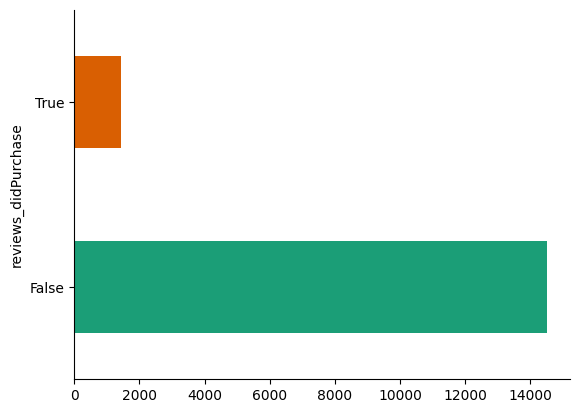

In [ ]:
# @title reviews_didPurchase

from matplotlib import pyplot as plt
import seaborn as sns
review.groupby('reviews_didPurchase').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

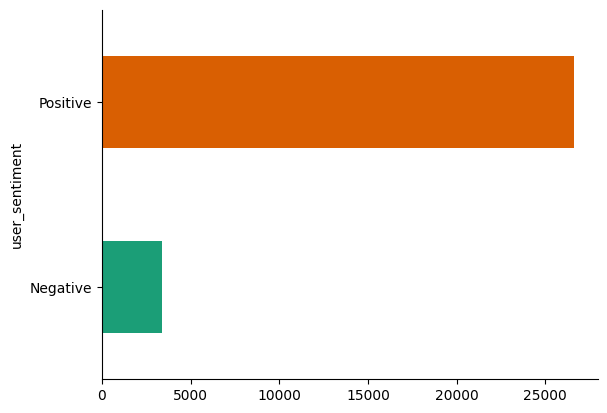

In [ ]:
# @title user_sentiment

from matplotlib import pyplot as plt
import seaborn as sns
review.groupby('user_sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

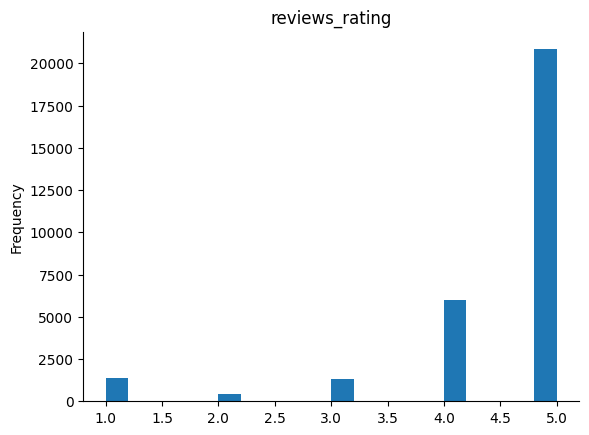

In [ ]:
# @title reviews_rating

from matplotlib import pyplot as plt
review['reviews_rating'].plot(kind='hist', bins=20, title='reviews_rating')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
encoding


'ISO-8859-1'

In [ ]:
user_dict = uniq_dict(review,"reviews_username")

No of unique values : 24915


In [ ]:
name_dict['100:Complete First Season (blu-Ray)']

83

In [ ]:
review2 = review

In [ ]:
review2['namemap'] = review['name'].apply(lambda x: name_dict[x])

In [ ]:
review2[['name','namemap']]

name  namemap
0              Pink Friday: Roman Reloaded Re-Up (w/dvd)        0
1             Lundberg Organic Cinnamon Toast Rice Cakes        1
2             Lundberg Organic Cinnamon Toast Rice Cakes        1
3                       K-Y Love Sensuality Pleasure Gel        2
4                       K-Y Love Sensuality Pleasure Gel        2
...                                                  ...      ...
29995  L'or233al Paris Elvive Extraordinary Clay Reba...      270
29996  L'or233al Paris Elvive Extraordinary Clay Reba...      270
29997  L'or233al Paris Elvive Extraordinary Clay Reba...      270
29998  L'or233al Paris Elvive Extraordinary Clay Reba...      270
29999  L'or233al Paris Elvive Extraordinary Clay Reba...      270

[30000 rows x 2 columns]

In [ ]:
name_dict['Lundberg Organic Cinnamon Toast Rice Cakes']

1

In [ ]:
for key, value in name_dict.items():
    # The if statement checks if the value of each item is equal to 56.
    if value == 270:
        # If the value is equal to 56, the key of that item is printed.
        print(key)

L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz
